In [1]:
import tensorflow as tf

/home/eblancoh/anaconda3/envs/universe/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Además de TensorFlow, importamos algunas librerías que pueden resultarnos de utilidad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Generamos un buen número de datos aleatorios de los que hacer uso para realizar la regresión:

In [3]:
# Elegimos el número de variables independientes
num_features = 1000000
# Generamos los valores de x 
x_data = np.linspace(0.0, 10.0, num_features)
# Y les metemos algo de ruido
x_data += np.random.uniform(-0.5,0.5,num_features)

In [4]:
x_data

array([-0.17719894,  0.11401191, -0.49075435, ..., 10.1016139 ,
       10.12465766,  9.55815042])

In [5]:
# Generamos las variables dependientes:
# y_label = m · x_data + b + ruido

# Elegimos m = 2.0 y b = 1.5

In [6]:
y_label = 2.0 * x_data + 1.5 + np.random.normal(-2, 2, num_features)

In [7]:
# Pandas nos permite ordenar en formato tabular todas nuestras variables para acceder de manera rápida a ellas
my_data = pd.concat([pd.DataFrame(data=x_data,columns=["x_data"]),
                     pd.DataFrame(data=y_label,columns=["y_label"])], 
                    axis = 1)

In [8]:
# Una breve muestra de cómo la variable "my_data" recoge las variables sobre las que se realizará la regresión
my_data.head()

,x_data,y_label
0,-0.177199,1.079974
1,0.114012,-0.332713
2,-0.490754,-0.707801
3,0.361175,5.625112
4,-0.193903,0.649785


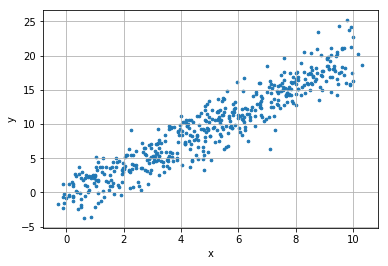

In [9]:
# Elegimos una muestra de 500 pares de datos para su representación. 
sampling = my_data.sample(n = 500)
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Dado el elevado número de variables que estamos manejando, debemos partir nuestro dataset en batches de un determinado tamaño para entrenar nuestro modelo.
Elegiremos un tamaño de batch de 10 puntos al azar cada vez.

In [10]:
batch_size = 10

In [11]:
# Inicializamos con valores aleatorios como variables la pendiente y la intersección 
# de nuestra recta a ajustar a los datos.
misc = np.random.rand(2)

m = tf.Variable(misc[0], dtype = tf.float32)
b = tf.Variable(misc[1], dtype = tf.float32)

In [12]:
x = tf.placeholder(tf.float32,[batch_size])
y = tf.placeholder(tf.float32,[batch_size])

In [14]:
# Se define la operación del ajuste lineal
y_model = m * x + b

La función de pérdida que vamos a usar se puede construir fácilmente con TensorFlow:

In [15]:
# Elegimos como función de coste la RMS.
error = tf.reduce_sum(tf.square(y - y_model))

In [16]:
# Podemos escoger el optimizador que deseemos. En este caso recurrimos a tf.train.GradientDescentOptimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
train = optimizer.minimize(error)

In [17]:
init = tf.global_variables_initializer()

In [18]:
with tf.Session() as sess:
    
    sess.run(init)
    # Elegimos un número de batches 
    num_batches = 10000
    
    for i in range(num_batches):
        
        # Creamos conjuntos de índices aleatorios de tamaño batch_size para muestrear en el dataset
        rand_ind = np.random.randint(num_features, size = batch_size)
        
        # Pasamos las variables en un feed dictionary: sess.run(operation, feed_dict={...})
        # La operación es la dirigida a minimizar el error a través del optimizador elegido
        sess.run(train, feed_dict= {x: x_data[rand_ind], y:y_label[rand_ind]})
        
    # Los resultados de la pendiente y el punto de intersección    
    final_m, final_b = sess.run([m, b])

In [19]:
# Los valores estimados para la pendiente "m" y el punto de intersección "b" son respectivamente:
print (final_m, final_b)

2.0298574 -0.4513363


## Evaluación del ajuste

In [20]:
# Elegimos un conjunto de variables independientes de prueba y obtenemos su predicción 
x_test = np.linspace(-1, 12, 50)
y_test = final_m * x_test + final_b

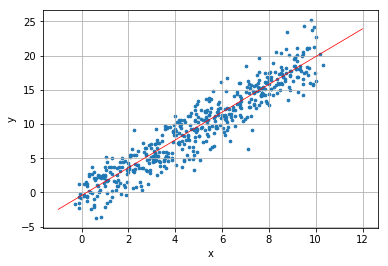

In [21]:
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.plot(x_test, y_test, 'r', linewidth = .75)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

La línea roja estimada por nuestro modelo se ajusta adecuadamente a la nube de puntos. 
El coeficiente de determinación r-squared para nuestro ajuste a toda la nube de puntos:

In [22]:
# Suma de los cuadrados de los residuos:
SS_res = np.sum((y_label - (final_m * x_data + final_b))**2)
# La suma de los cuadrados totales se define como:
SS_tot = np.sum((y_label - np.mean(y_label))**2)

# El coeficiente r**2 se define como:
r_squared = 1 - SS_res/SS_tot

In [23]:
r_squared

0.8926266330367192

## tf.estimator API

En esta parte del notebook se proporciona una introducción al uso de los Estimadores en TensorFlow. Estos estimadores son
una API de TensorFlow que simplifican la programación de algortimos de Machine Learning. 
Los Estimadores encapsulan el entrenamiento, evaluación y predicción.
Además, son capaces de construir el grafo, inicializar variables, crear checkpoints del modelo y guardar summaries para TensorBoard.

In [24]:
feat_cols = [tf.feature_column.numeric_column("x", shape=[1])]

In [25]:
estimator = tf.estimator.LinearRegressor(feature_columns = feat_cols)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc4cb7c0d68>, '_service': None, '_tf_random_seed': None, '_session_config': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_is_chief': True, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_num_worker_replicas': 1, '_save_checkpoints_steps': None, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpifm391a6', '_keep_checkpoint_max': 5}


### Partición del dataset en conjuntos de entrenamiento y evaluación

In [26]:
# Hacemos uso de la función train_test_split de sklearn
from sklearn.model_selection import train_test_split

In [30]:
# Definimos los datos de entrenamiento y evaluación del modelo. Elegimos una razón 3:1
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_label, test_size=0.25)

In [31]:
print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)

### Generación de los inputs con los que alimentaremos al estimador

In [36]:
input_func = tf.estimator.inputs.numpy_input_fn({"x": x_train}, y_train, batch_size=10, num_epochs=None, shuffle=True)

In [38]:
train_input_func = tf.estimator.inputs.numpy_input_fn({"x": x_train}, y_train, batch_size=10, num_epochs=10000, shuffle=False)

In [40]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({"x": x_eval}, y_eval, batch_size=10, num_epochs=10000, shuffle=False)

### Entrenamiento del estimador

In [41]:
estimator.train(input_fn = input_func, steps = 100000)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpifm391a6/model.ckpt.


INFO:tensorflow:loss = 1106.0292, step = 1


INFO:tensorflow:global_step/sec: 509.46


INFO:tensorflow:loss = 19.553398, step = 101 (0.199 sec)

INFO:tensorflow:global_step/sec: 546.451


INFO:tensorflow:loss = 37.06066, step = 201 (0.187 sec)


INFO:tensorflow:global_step/sec: 585.132


INFO:tensorflow:loss = 69.74838, step = 301 (0.180 sec)


INFO:tensorflow:global_step/sec: 545.003


INFO:tensorflow:loss = 37.5836, step = 401 (0.193 sec)


INFO:tensorflow:global_step/sec: 468.927


INFO:tensorflow:loss = 57.744736, step = 501 (0.194 sec)


INFO:tensorflow:global_step/sec: 456.022


INFO:tensorflow:loss = 18.495138, step = 601 (0.216 sec)


INFO:tensorflow:global_step/sec: 538.647


INFO:tensorflow:loss = 23.458754, step = 701 (0.194 sec)


INFO:tensorflow:global_step/sec: 604.018


INFO:tensorflow:loss = 42.12982, step = 801 (0.158 sec)


INFO:tensorflow:global_step/sec: 561.299


INFO:tensorflow:loss = 45.5726, step = 901 (0.178 sec)


INFO:tensorflow:global_step/sec: 454.076


INFO:tensorflow:loss = 68.49663, step = 1001 (0.225 sec)


INFO:tensorflow:global_step/sec: 544.817


INFO:tensorflow:loss = 20.79467, step = 1101 (0.185 sec)


INFO:tensorflow:global_step/sec: 409.21


INFO:tensorflow:loss = 30.359707, step = 1201 (0.239 sec)


INFO:tensorflow:global_step/sec: 485.372


INFO:tensorflow:loss = 33.41319, step = 1301 (0.205 sec)


INFO:tensorflow:global_step/sec: 555.313


INFO:tensorflow:loss = 80.193634, step = 1401 (0.178 sec)


INFO:tensorflow:global_step/sec: 409.969


INFO:tensorflow:loss = 30.325245, step = 1501 (0.247 sec)


INFO:tensorflow:global_step/sec: 390.66


INFO:tensorflow:loss = 34.45107, step = 1601 (0.264 sec)


INFO:tensorflow:global_step/sec: 465.326


INFO:tensorflow:loss = 46.336906, step = 1701 (0.218 sec)


INFO:tensorflow:global_step/sec: 568.871


INFO:tensorflow:loss = 13.798572, step = 1801 (0.165 sec)


INFO:tensorflow:global_step/sec: 450.68


INFO:tensorflow:loss = 34.59292, step = 1901 (0.218 sec)


INFO:tensorflow:global_step/sec: 406.617


INFO:tensorflow:loss = 25.574377, step = 2001 (0.268 sec)


INFO:tensorflow:global_step/sec: 415.335


INFO:tensorflow:loss = 47.00791, step = 2101 (0.230 sec)


INFO:tensorflow:global_step/sec: 529.047


INFO:tensorflow:loss = 75.7154, step = 2201 (0.182 sec)


INFO:tensorflow:global_step/sec: 430.319


INFO:tensorflow:loss = 73.24395, step = 2301 (0.236 sec)


INFO:tensorflow:global_step/sec: 410.846


INFO:tensorflow:loss = 65.904785, step = 2401 (0.243 sec)


INFO:tensorflow:global_step/sec: 583.832


INFO:tensorflow:loss = 43.15178, step = 2501 (0.175 sec)


INFO:tensorflow:global_step/sec: 510.399


INFO:tensorflow:loss = 24.002151, step = 2601 (0.187 sec)


INFO:tensorflow:global_step/sec: 456.347


INFO:tensorflow:loss = 69.74092, step = 2701 (0.246 sec)


INFO:tensorflow:global_step/sec: 460.271


INFO:tensorflow:loss = 52.917652, step = 2801 (0.191 sec)


INFO:tensorflow:global_step/sec: 426.333


INFO:tensorflow:loss = 110.365585, step = 2901 (0.245 sec)


INFO:tensorflow:global_step/sec: 647.287


INFO:tensorflow:loss = 49.79603, step = 3001 (0.164 sec)


INFO:tensorflow:global_step/sec: 661.063


INFO:tensorflow:loss = 30.223946, step = 3101 (0.139 sec)


INFO:tensorflow:global_step/sec: 579.085


INFO:tensorflow:loss = 58.70469, step = 3201 (0.179 sec)


INFO:tensorflow:global_step/sec: 499.046

INFO:tensorflow:loss = 43.086735, step = 3301 (0.201 sec)


INFO:tensorflow:global_step/sec: 433.956


INFO:tensorflow:loss = 41.65915, step = 3401 (0.216 sec)


INFO:tensorflow:global_step/sec: 485.347


INFO:tensorflow:loss = 53.377563, step = 3501 (0.230 sec)


INFO:tensorflow:global_step/sec: 517.445


INFO:tensorflow:loss = 45.498962, step = 3601 (0.184 sec)


INFO:tensorflow:global_step/sec: 539.961


INFO:tensorflow:loss = 49.742073, step = 3701 (0.182 sec)

INFO:tensorflow:global_step/sec: 412.555


INFO:tensorflow:loss = 17.24031, step = 3801 (0.236 sec)


INFO:tensorflow:global_step/sec: 435.528


INFO:tensorflow:loss = 53.06418, step = 3901 (0.223 sec)


INFO:tensorflow:global_step/sec: 609.7


INFO:tensorflow:loss = 71.01014, step = 4001 (0.167 sec)


INFO:tensorflow:global_step/sec: 678.193


INFO:tensorflow:loss = 20.618658, step = 4101 (0.143 sec)


INFO:tensorflow:global_step/sec: 600.437


INFO:tensorflow:loss = 88.38331, step = 4201 (0.175 sec)


INFO:tensorflow:global_step/sec: 665.456


INFO:tensorflow:loss = 66.98267, step = 4301 (0.146 sec)


INFO:tensorflow:global_step/sec: 567.968


INFO:tensorflow:loss = 63.397972, step = 4401 (0.172 sec)


INFO:tensorflow:global_step/sec: 587.525


INFO:tensorflow:loss = 33.365997, step = 4501 (0.170 sec)


INFO:tensorflow:global_step/sec: 535.216


INFO:tensorflow:loss = 39.858307, step = 4601 (0.187 sec)


INFO:tensorflow:global_step/sec: 555.14


INFO:tensorflow:loss = 43.01642, step = 4701 (0.180 sec)


INFO:tensorflow:global_step/sec: 637.924


INFO:tensorflow:loss = 67.57264, step = 4801 (0.161 sec)


INFO:tensorflow:global_step/sec: 691.882


INFO:tensorflow:loss = 29.85647, step = 4901 (0.144 sec)


INFO:tensorflow:global_step/sec: 579.074


INFO:tensorflow:loss = 60.88194, step = 5001 (0.175 sec)


INFO:tensorflow:global_step/sec: 640.479


INFO:tensorflow:loss = 31.830961, step = 5101 (0.154 sec)


INFO:tensorflow:global_step/sec: 500.444

INFO:tensorflow:loss = 49.78557, step = 5201 (0.204 sec)


INFO:tensorflow:global_step/sec: 579.566


INFO:tensorflow:loss = 46.23254, step = 5301 (0.178 sec)


INFO:tensorflow:global_step/sec: 514.912


INFO:tensorflow:loss = 34.847588, step = 5401 (0.190 sec)


INFO:tensorflow:global_step/sec: 620.265


INFO:tensorflow:loss = 24.727362, step = 5501 (0.161 sec)


INFO:tensorflow:global_step/sec: 556.334


INFO:tensorflow:loss = 32.35558, step = 5601 (0.176 sec)


INFO:tensorflow:global_step/sec: 594.806


INFO:tensorflow:loss = 32.34529, step = 5701 (0.186 sec)


INFO:tensorflow:global_step/sec: 449.08


INFO:tensorflow:loss = 41.591026, step = 5801 (0.203 sec)


INFO:tensorflow:global_step/sec: 617.07


INFO:tensorflow:loss = 20.752903, step = 5901 (0.161 sec)


INFO:tensorflow:global_step/sec: 428.212


INFO:tensorflow:loss = 75.923584, step = 6001 (0.246 sec)


INFO:tensorflow:global_step/sec: 461.154

INFO:tensorflow:loss = 25.398441, step = 6101 (0.208 sec)


INFO:tensorflow:global_step/sec: 590.242


INFO:tensorflow:loss = 43.203747, step = 6201 (0.174 sec)


INFO:tensorflow:global_step/sec: 408.072


INFO:tensorflow:loss = 19.079302, step = 6301 (0.249 sec)


INFO:tensorflow:global_step/sec: 576.643


INFO:tensorflow:loss = 60.588135, step = 6401 (0.161 sec)


INFO:tensorflow:global_step/sec: 557.559


INFO:tensorflow:loss = 26.271572, step = 6501 (0.181 sec)


INFO:tensorflow:global_step/sec: 549.038


INFO:tensorflow:loss = 30.85894, step = 6601 (0.196 sec)


INFO:tensorflow:global_step/sec: 496.078


INFO:tensorflow:loss = 35.719826, step = 6701 (0.192 sec)


INFO:tensorflow:global_step/sec: 452.756


INFO:tensorflow:loss = 50.11329, step = 6801 (0.215 sec)


INFO:tensorflow:global_step/sec: 600.458


INFO:tensorflow:loss = 36.739983, step = 6901 (0.167 sec)


INFO:tensorflow:global_step/sec: 473.449


INFO:tensorflow:loss = 24.42018, step = 7001 (0.213 sec)


INFO:tensorflow:global_step/sec: 483.965


INFO:tensorflow:loss = 31.155842, step = 7101 (0.206 sec)


INFO:tensorflow:global_step/sec: 593.946


INFO:tensorflow:loss = 22.6507, step = 7201 (0.169 sec)


INFO:tensorflow:global_step/sec: 460.208


INFO:tensorflow:loss = 38.99468, step = 7301 (0.217 sec)


INFO:tensorflow:global_step/sec: 463.452


INFO:tensorflow:loss = 39.501133, step = 7401 (0.216 sec)


INFO:tensorflow:global_step/sec: 584.672


INFO:tensorflow:loss = 22.433382, step = 7501 (0.169 sec)


INFO:tensorflow:global_step/sec: 471.953


INFO:tensorflow:loss = 46.162735, step = 7601 (0.218 sec)


INFO:tensorflow:global_step/sec: 586.829


INFO:tensorflow:loss = 37.779682, step = 7701 (0.165 sec)


INFO:tensorflow:global_step/sec: 506.495


INFO:tensorflow:loss = 22.667997, step = 7801 (0.205 sec)


INFO:tensorflow:global_step/sec: 418.928


INFO:tensorflow:loss = 37.528137, step = 7901 (0.234 sec)


INFO:tensorflow:global_step/sec: 598.46


INFO:tensorflow:loss = 60.76066, step = 8001 (0.171 sec)


INFO:tensorflow:global_step/sec: 504.613


INFO:tensorflow:loss = 42.094467, step = 8101 (0.192 sec)


INFO:tensorflow:global_step/sec: 455.41


INFO:tensorflow:loss = 40.513775, step = 8201 (0.225 sec)


INFO:tensorflow:global_step/sec: 523.324


INFO:tensorflow:loss = 79.80004, step = 8301 (0.190 sec)


INFO:tensorflow:global_step/sec: 396.775


INFO:tensorflow:loss = 69.31611, step = 8401 (0.250 sec)


INFO:tensorflow:global_step/sec: 548.737


INFO:tensorflow:loss = 45.740143, step = 8501 (0.183 sec)


INFO:tensorflow:global_step/sec: 602.795


INFO:tensorflow:loss = 46.527737, step = 8601 (0.164 sec)


INFO:tensorflow:global_step/sec: 453.608


INFO:tensorflow:loss = 60.17758, step = 8701 (0.224 sec)


INFO:tensorflow:global_step/sec: 630.226


INFO:tensorflow:loss = 21.274149, step = 8801 (0.157 sec)


INFO:tensorflow:global_step/sec: 544.634


INFO:tensorflow:loss = 49.180996, step = 8901 (0.184 sec)


INFO:tensorflow:global_step/sec: 544.643


INFO:tensorflow:loss = 38.46146, step = 9001 (0.181 sec)


INFO:tensorflow:global_step/sec: 605.693


INFO:tensorflow:loss = 32.293686, step = 9101 (0.173 sec)


INFO:tensorflow:global_step/sec: 650.713


INFO:tensorflow:loss = 35.38125, step = 9201 (0.147 sec)


INFO:tensorflow:global_step/sec: 508.153


INFO:tensorflow:loss = 33.500805, step = 9301 (0.205 sec)

INFO:tensorflow:global_step/sec: 547.347


INFO:tensorflow:loss = 79.81104, step = 9401 (0.179 sec)


INFO:tensorflow:global_step/sec: 697.918


INFO:tensorflow:loss = 62.043633, step = 9501 (0.140 sec)


INFO:tensorflow:global_step/sec: 484.958


INFO:tensorflow:loss = 39.502983, step = 9601 (0.205 sec)


INFO:tensorflow:global_step/sec: 568.835


INFO:tensorflow:loss = 43.378033, step = 9701 (0.176 sec)


INFO:tensorflow:global_step/sec: 557.698


INFO:tensorflow:loss = 35.79775, step = 9801 (0.179 sec)


INFO:tensorflow:global_step/sec: 835.923


INFO:tensorflow:loss = 62.055622, step = 9901 (0.121 sec)


INFO:tensorflow:global_step/sec: 582.136


INFO:tensorflow:loss = 19.644413, step = 10001 (0.174 sec)


INFO:tensorflow:global_step/sec: 640.266


INFO:tensorflow:loss = 28.53746, step = 10101 (0.164 sec)


INFO:tensorflow:global_step/sec: 629.908


INFO:tensorflow:loss = 56.131805, step = 10201 (0.146 sec)


INFO:tensorflow:global_step/sec: 568.545


INFO:tensorflow:loss = 20.280678, step = 10301 (0.182 sec)


INFO:tensorflow:global_step/sec: 540.271


INFO:tensorflow:loss = 16.07212, step = 10401 (0.180 sec)


INFO:tensorflow:global_step/sec: 537.286


INFO:tensorflow:loss = 14.98032, step = 10501 (0.185 sec)


INFO:tensorflow:global_step/sec: 562.104


INFO:tensorflow:loss = 33.85304, step = 10601 (0.199 sec)


INFO:tensorflow:global_step/sec: 575.02


INFO:tensorflow:loss = 64.16911, step = 10701 (0.163 sec)


INFO:tensorflow:global_step/sec: 451.683


INFO:tensorflow:loss = 14.784823, step = 10801 (0.214 sec)


INFO:tensorflow:global_step/sec: 526.869


INFO:tensorflow:loss = 62.966732, step = 10901 (0.189 sec)


INFO:tensorflow:global_step/sec: 484.222


INFO:tensorflow:loss = 44.749046, step = 11001 (0.213 sec)


INFO:tensorflow:global_step/sec: 577.186


INFO:tensorflow:loss = 56.365738, step = 11101 (0.165 sec)


INFO:tensorflow:global_step/sec: 553.72


INFO:tensorflow:loss = 50.5984, step = 11201 (0.182 sec)


INFO:tensorflow:global_step/sec: 507.682


INFO:tensorflow:loss = 29.407393, step = 11301 (0.197 sec)


INFO:tensorflow:global_step/sec: 510.443


INFO:tensorflow:loss = 36.87689, step = 11401 (0.204 sec)


INFO:tensorflow:global_step/sec: 551.754


INFO:tensorflow:loss = 76.03826, step = 11501 (0.172 sec)


INFO:tensorflow:global_step/sec: 603.798


INFO:tensorflow:loss = 20.566525, step = 11601 (0.168 sec)


INFO:tensorflow:global_step/sec: 488.161

INFO:tensorflow:loss = 73.29635, step = 11701 (0.209 sec)


INFO:tensorflow:global_step/sec: 504.248


INFO:tensorflow:loss = 25.182903, step = 11801 (0.193 sec)


INFO:tensorflow:global_step/sec: 571.135


INFO:tensorflow:loss = 42.58846, step = 11901 (0.175 sec)


INFO:tensorflow:global_step/sec: 707.933


INFO:tensorflow:loss = 20.393803, step = 12001 (0.159 sec)


INFO:tensorflow:global_step/sec: 461.018


INFO:tensorflow:loss = 66.07344, step = 12101 (0.213 sec)


INFO:tensorflow:global_step/sec: 605.954


INFO:tensorflow:loss = 42.34979, step = 12201 (0.150 sec)


INFO:tensorflow:global_step/sec: 595.237


INFO:tensorflow:loss = 21.305971, step = 12301 (0.167 sec)


INFO:tensorflow:global_step/sec: 453.455


INFO:tensorflow:loss = 30.862434, step = 12401 (0.224 sec)


INFO:tensorflow:global_step/sec: 544.852


INFO:tensorflow:loss = 57.602295, step = 12501 (0.180 sec)


INFO:tensorflow:global_step/sec: 736.025


INFO:tensorflow:loss = 23.235958, step = 12601 (0.138 sec)


INFO:tensorflow:global_step/sec: 570.079


INFO:tensorflow:loss = 41.263374, step = 12701 (0.173 sec)


INFO:tensorflow:global_step/sec: 657.591


INFO:tensorflow:loss = 12.907517, step = 12801 (0.165 sec)


INFO:tensorflow:global_step/sec: 507.346


INFO:tensorflow:loss = 33.47323, step = 12901 (0.185 sec)


INFO:tensorflow:global_step/sec: 745.523


INFO:tensorflow:loss = 53.408752, step = 13001 (0.135 sec)


INFO:tensorflow:global_step/sec: 577.05


INFO:tensorflow:loss = 44.107254, step = 13101 (0.176 sec)


INFO:tensorflow:global_step/sec: 621.702


INFO:tensorflow:loss = 55.36311, step = 13201 (0.163 sec)


INFO:tensorflow:global_step/sec: 741.164


INFO:tensorflow:loss = 25.00606, step = 13301 (0.129 sec)


INFO:tensorflow:global_step/sec: 556.328


INFO:tensorflow:loss = 20.692806, step = 13401 (0.180 sec)


INFO:tensorflow:global_step/sec: 774.613


INFO:tensorflow:loss = 24.28754, step = 13501 (0.129 sec)


INFO:tensorflow:global_step/sec: 633.305


INFO:tensorflow:loss = 23.451881, step = 13601 (0.158 sec)


INFO:tensorflow:global_step/sec: 553.775


INFO:tensorflow:loss = 77.33387, step = 13701 (0.184 sec)


INFO:tensorflow:global_step/sec: 617.604


INFO:tensorflow:loss = 51.470802, step = 13801 (0.158 sec)


INFO:tensorflow:global_step/sec: 660.092


INFO:tensorflow:loss = 63.656216, step = 13901 (0.157 sec)


INFO:tensorflow:global_step/sec: 707.914


INFO:tensorflow:loss = 27.946293, step = 14001 (0.138 sec)


INFO:tensorflow:global_step/sec: 878.359


INFO:tensorflow:loss = 53.441013, step = 14101 (0.112 sec)


INFO:tensorflow:global_step/sec: 401.907


INFO:tensorflow:loss = 19.949133, step = 14201 (0.253 sec)


INFO:tensorflow:global_step/sec: 456.287


INFO:tensorflow:loss = 45.10083, step = 14301 (0.223 sec)


INFO:tensorflow:global_step/sec: 619.199


INFO:tensorflow:loss = 45.511475, step = 14401 (0.159 sec)


INFO:tensorflow:global_step/sec: 472.009


INFO:tensorflow:loss = 61.998543, step = 14501 (0.208 sec)


INFO:tensorflow:global_step/sec: 468.539


INFO:tensorflow:loss = 86.9577, step = 14601 (0.217 sec)


INFO:tensorflow:global_step/sec: 442.02


INFO:tensorflow:loss = 48.87424, step = 14701 (0.226 sec)


INFO:tensorflow:global_step/sec: 597.771


INFO:tensorflow:loss = 49.420803, step = 14801 (0.167 sec)


INFO:tensorflow:global_step/sec: 696.766


INFO:tensorflow:loss = 42.943123, step = 14901 (0.141 sec)


INFO:tensorflow:global_step/sec: 669.548


INFO:tensorflow:loss = 45.003, step = 15001 (0.147 sec)


INFO:tensorflow:global_step/sec: 641.151


INFO:tensorflow:loss = 35.84317, step = 15101 (0.158 sec)


INFO:tensorflow:global_step/sec: 502.16


INFO:tensorflow:loss = 28.895014, step = 15201 (0.197 sec)


INFO:tensorflow:global_step/sec: 706.239


INFO:tensorflow:loss = 21.677635, step = 15301 (0.144 sec)


INFO:tensorflow:global_step/sec: 595.536


INFO:tensorflow:loss = 27.807608, step = 15401 (0.171 sec)


INFO:tensorflow:global_step/sec: 474.094


INFO:tensorflow:loss = 26.107338, step = 15501 (0.215 sec)


INFO:tensorflow:global_step/sec: 503.601


INFO:tensorflow:loss = 75.93984, step = 15601 (0.188 sec)


INFO:tensorflow:global_step/sec: 629.705


INFO:tensorflow:loss = 25.558796, step = 15701 (0.163 sec)


INFO:tensorflow:global_step/sec: 590.824


INFO:tensorflow:loss = 49.221832, step = 15801 (0.165 sec)


INFO:tensorflow:global_step/sec: 671.795


INFO:tensorflow:loss = 19.426159, step = 15901 (0.149 sec)


INFO:tensorflow:global_step/sec: 601.206


INFO:tensorflow:loss = 39.386208, step = 16001 (0.167 sec)


INFO:tensorflow:global_step/sec: 568.107


INFO:tensorflow:loss = 37.50071, step = 16101 (0.176 sec)


INFO:tensorflow:global_step/sec: 726.752


INFO:tensorflow:loss = 50.805527, step = 16201 (0.138 sec)


INFO:tensorflow:global_step/sec: 494.661

INFO:tensorflow:loss = 116.2595, step = 16301 (0.202 sec)


INFO:tensorflow:global_step/sec: 560.633


INFO:tensorflow:loss = 59.32171, step = 16401 (0.178 sec)


INFO:tensorflow:global_step/sec: 450.523


INFO:tensorflow:loss = 21.473625, step = 16501 (0.222 sec)


INFO:tensorflow:global_step/sec: 540.482


INFO:tensorflow:loss = 54.68357, step = 16601 (0.186 sec)


INFO:tensorflow:global_step/sec: 486.721


INFO:tensorflow:loss = 24.719833, step = 16701 (0.204 sec)


INFO:tensorflow:global_step/sec: 729.262


INFO:tensorflow:loss = 20.515581, step = 16801 (0.140 sec)


INFO:tensorflow:global_step/sec: 551.936


INFO:tensorflow:loss = 47.730988, step = 16901 (0.178 sec)


INFO:tensorflow:global_step/sec: 510.47


INFO:tensorflow:loss = 10.877808, step = 17001 (0.200 sec)

INFO:tensorflow:global_step/sec: 643.296


INFO:tensorflow:loss = 33.950554, step = 17101 (0.155 sec)


INFO:tensorflow:global_step/sec: 741.22


INFO:tensorflow:loss = 34.29349, step = 17201 (0.140 sec)


INFO:tensorflow:global_step/sec: 618.165


INFO:tensorflow:loss = 37.595795, step = 17301 (0.160 sec)


INFO:tensorflow:global_step/sec: 528.438


INFO:tensorflow:loss = 18.317787, step = 17401 (0.183 sec)


INFO:tensorflow:global_step/sec: 697.141


INFO:tensorflow:loss = 45.143204, step = 17501 (0.142 sec)


INFO:tensorflow:global_step/sec: 537.267


INFO:tensorflow:loss = 16.83702, step = 17601 (0.186 sec)


INFO:tensorflow:global_step/sec: 663.575


INFO:tensorflow:loss = 67.33163, step = 17701 (0.155 sec)


INFO:tensorflow:global_step/sec: 664.056


INFO:tensorflow:loss = 42.19362, step = 17801 (0.150 sec)


INFO:tensorflow:global_step/sec: 608.568


INFO:tensorflow:loss = 33.940018, step = 17901 (0.161 sec)


INFO:tensorflow:global_step/sec: 608.853


INFO:tensorflow:loss = 68.34369, step = 18001 (0.165 sec)


INFO:tensorflow:global_step/sec: 542.548


INFO:tensorflow:loss = 58.361183, step = 18101 (0.185 sec)


INFO:tensorflow:global_step/sec: 622.555


INFO:tensorflow:loss = 27.27889, step = 18201 (0.162 sec)


INFO:tensorflow:global_step/sec: 951.737


INFO:tensorflow:loss = 19.07182, step = 18301 (0.105 sec)


INFO:tensorflow:global_step/sec: 594.821


INFO:tensorflow:loss = 65.41791, step = 18401 (0.167 sec)


INFO:tensorflow:global_step/sec: 522.982


INFO:tensorflow:loss = 45.672962, step = 18501 (0.201 sec)


INFO:tensorflow:global_step/sec: 547.962


INFO:tensorflow:loss = 41.02322, step = 18601 (0.172 sec)


INFO:tensorflow:global_step/sec: 452.678


INFO:tensorflow:loss = 21.904099, step = 18701 (0.224 sec)


INFO:tensorflow:global_step/sec: 511.708


INFO:tensorflow:loss = 30.081345, step = 18801 (0.195 sec)

INFO:tensorflow:global_step/sec: 578.311


INFO:tensorflow:loss = 39.70587, step = 18901 (0.170 sec)


INFO:tensorflow:global_step/sec: 495.936

INFO:tensorflow:loss = 52.829704, step = 19001 (0.218 sec)


INFO:tensorflow:global_step/sec: 428.563


INFO:tensorflow:loss = 53.605892, step = 19101 (0.221 sec)


INFO:tensorflow:global_step/sec: 730.328


INFO:tensorflow:loss = 63.3757, step = 19201 (0.133 sec)


INFO:tensorflow:global_step/sec: 676.639


INFO:tensorflow:loss = 45.84713, step = 19301 (0.151 sec)


INFO:tensorflow:global_step/sec: 497.207

INFO:tensorflow:loss = 81.73697, step = 19401 (0.198 sec)

INFO:tensorflow:global_step/sec: 747.553


INFO:tensorflow:loss = 33.947697, step = 19501 (0.137 sec)


INFO:tensorflow:global_step/sec: 632.005


INFO:tensorflow:loss = 33.8668, step = 19601 (0.162 sec)


INFO:tensorflow:global_step/sec: 576.08


INFO:tensorflow:loss = 24.656414, step = 19701 (0.169 sec)


INFO:tensorflow:global_step/sec: 599.716


INFO:tensorflow:loss = 16.942823, step = 19801 (0.166 sec)


INFO:tensorflow:global_step/sec: 491.076


INFO:tensorflow:loss = 17.342787, step = 19901 (0.203 sec)


INFO:tensorflow:global_step/sec: 581.199


INFO:tensorflow:loss = 36.772472, step = 20001 (0.172 sec)


INFO:tensorflow:global_step/sec: 414.94


INFO:tensorflow:loss = 57.97924, step = 20101 (0.239 sec)


INFO:tensorflow:global_step/sec: 514.949


INFO:tensorflow:loss = 25.03125, step = 20201 (0.194 sec)


INFO:tensorflow:global_step/sec: 401.467


INFO:tensorflow:loss = 56.000057, step = 20301 (0.259 sec)


INFO:tensorflow:global_step/sec: 527.833


INFO:tensorflow:loss = 35.65973, step = 20401 (0.183 sec)

INFO:tensorflow:global_step/sec: 554.509


INFO:tensorflow:loss = 29.216053, step = 20501 (0.183 sec)


INFO:tensorflow:global_step/sec: 602.478


INFO:tensorflow:loss = 27.310837, step = 20601 (0.160 sec)


INFO:tensorflow:global_step/sec: 648.538


INFO:tensorflow:loss = 40.759117, step = 20701 (0.158 sec)


INFO:tensorflow:global_step/sec: 590.41


INFO:tensorflow:loss = 50.755123, step = 20801 (0.166 sec)


INFO:tensorflow:global_step/sec: 447.287


INFO:tensorflow:loss = 43.946774, step = 20901 (0.226 sec)


INFO:tensorflow:global_step/sec: 489.106


INFO:tensorflow:loss = 25.399591, step = 21001 (0.202 sec)


INFO:tensorflow:global_step/sec: 557.052


INFO:tensorflow:loss = 28.694809, step = 21101 (0.183 sec)


INFO:tensorflow:global_step/sec: 587.786


INFO:tensorflow:loss = 22.205536, step = 21201 (0.175 sec)


INFO:tensorflow:global_step/sec: 478.558

INFO:tensorflow:loss = 34.77876, step = 21301 (0.222 sec)


INFO:tensorflow:global_step/sec: 493.365


INFO:tensorflow:loss = 54.79047, step = 21401 (0.188 sec)


INFO:tensorflow:global_step/sec: 587.692


INFO:tensorflow:loss = 60.42587, step = 21501 (0.167 sec)


INFO:tensorflow:global_step/sec: 420.714


INFO:tensorflow:loss = 43.148575, step = 21601 (0.234 sec)


INFO:tensorflow:global_step/sec: 562.659


INFO:tensorflow:loss = 26.302837, step = 21701 (0.178 sec)


INFO:tensorflow:global_step/sec: 384.818


INFO:tensorflow:loss = 38.383034, step = 21801 (0.262 sec)


INFO:tensorflow:global_step/sec: 684.238


INFO:tensorflow:loss = 109.70413, step = 21901 (0.146 sec)


INFO:tensorflow:global_step/sec: 807.89


INFO:tensorflow:loss = 30.514488, step = 22001 (0.126 sec)


INFO:tensorflow:global_step/sec: 489.484


INFO:tensorflow:loss = 37.098877, step = 22101 (0.200 sec)


INFO:tensorflow:global_step/sec: 577.302


INFO:tensorflow:loss = 34.669838, step = 22201 (0.173 sec)


INFO:tensorflow:global_step/sec: 546.573


INFO:tensorflow:loss = 10.394462, step = 22301 (0.183 sec)


INFO:tensorflow:global_step/sec: 607.378


INFO:tensorflow:loss = 29.950994, step = 22401 (0.165 sec)


INFO:tensorflow:global_step/sec: 427.344


INFO:tensorflow:loss = 22.938084, step = 22501 (0.238 sec)


INFO:tensorflow:global_step/sec: 388.393


INFO:tensorflow:loss = 30.543018, step = 22601 (0.256 sec)


INFO:tensorflow:global_step/sec: 551.305


INFO:tensorflow:loss = 55.42665, step = 22701 (0.181 sec)


INFO:tensorflow:global_step/sec: 563.91


INFO:tensorflow:loss = 38.936855, step = 22801 (0.176 sec)


INFO:tensorflow:global_step/sec: 601.348


INFO:tensorflow:loss = 46.822853, step = 22901 (0.167 sec)


INFO:tensorflow:global_step/sec: 511.407


INFO:tensorflow:loss = 27.462618, step = 23001 (0.194 sec)


INFO:tensorflow:global_step/sec: 541.895


INFO:tensorflow:loss = 35.46926, step = 23101 (0.184 sec)


INFO:tensorflow:global_step/sec: 479.384


INFO:tensorflow:loss = 47.243237, step = 23201 (0.226 sec)


INFO:tensorflow:global_step/sec: 653.473


INFO:tensorflow:loss = 47.95838, step = 23301 (0.137 sec)


INFO:tensorflow:global_step/sec: 708.697


INFO:tensorflow:loss = 55.510334, step = 23401 (0.141 sec)


INFO:tensorflow:global_step/sec: 759.809


INFO:tensorflow:loss = 48.064495, step = 23501 (0.133 sec)


INFO:tensorflow:global_step/sec: 839.243


INFO:tensorflow:loss = 21.432272, step = 23601 (0.119 sec)


INFO:tensorflow:global_step/sec: 835.892


INFO:tensorflow:loss = 38.377014, step = 23701 (0.122 sec)


INFO:tensorflow:global_step/sec: 627.861


INFO:tensorflow:loss = 50.620735, step = 23801 (0.158 sec)


INFO:tensorflow:global_step/sec: 517.323


INFO:tensorflow:loss = 35.67965, step = 23901 (0.197 sec)


INFO:tensorflow:global_step/sec: 864.212


INFO:tensorflow:loss = 39.203003, step = 24001 (0.112 sec)


INFO:tensorflow:global_step/sec: 515.558


INFO:tensorflow:loss = 35.981003, step = 24101 (0.193 sec)


INFO:tensorflow:global_step/sec: 420.058


INFO:tensorflow:loss = 30.452187, step = 24201 (0.238 sec)


INFO:tensorflow:global_step/sec: 491.815

INFO:tensorflow:loss = 37.82223, step = 24301 (0.203 sec)


INFO:tensorflow:global_step/sec: 639.667


INFO:tensorflow:loss = 23.64659, step = 24401 (0.157 sec)


INFO:tensorflow:global_step/sec: 498.963


INFO:tensorflow:loss = 32.798496, step = 24501 (0.204 sec)


INFO:tensorflow:global_step/sec: 503.835


INFO:tensorflow:loss = 38.862595, step = 24601 (0.194 sec)


INFO:tensorflow:global_step/sec: 629.429


INFO:tensorflow:loss = 46.981773, step = 24701 (0.159 sec)


INFO:tensorflow:global_step/sec: 802.11


INFO:tensorflow:loss = 35.225945, step = 24801 (0.125 sec)


INFO:tensorflow:global_step/sec: 614.801


INFO:tensorflow:loss = 40.37303, step = 24901 (0.161 sec)


INFO:tensorflow:global_step/sec: 763.007


INFO:tensorflow:loss = 30.676851, step = 25001 (0.132 sec)


INFO:tensorflow:global_step/sec: 824.639


INFO:tensorflow:loss = 49.785625, step = 25101 (0.120 sec)


INFO:tensorflow:global_step/sec: 719.992


INFO:tensorflow:loss = 29.51332, step = 25201 (0.142 sec)


INFO:tensorflow:global_step/sec: 668.846


INFO:tensorflow:loss = 46.14235, step = 25301 (0.149 sec)


INFO:tensorflow:global_step/sec: 549.156


INFO:tensorflow:loss = 36.53656, step = 25401 (0.180 sec)


INFO:tensorflow:global_step/sec: 507.34


INFO:tensorflow:loss = 20.64933, step = 25501 (0.197 sec)


INFO:tensorflow:global_step/sec: 637.32


INFO:tensorflow:loss = 12.242617, step = 25601 (0.157 sec)


INFO:tensorflow:global_step/sec: 702.567


INFO:tensorflow:loss = 32.92355, step = 25701 (0.143 sec)


INFO:tensorflow:global_step/sec: 704.298


INFO:tensorflow:loss = 47.11822, step = 25801 (0.140 sec)


INFO:tensorflow:global_step/sec: 417.092


INFO:tensorflow:loss = 44.63491, step = 25901 (0.249 sec)


INFO:tensorflow:global_step/sec: 483.721


INFO:tensorflow:loss = 28.213045, step = 26001 (0.207 sec)


INFO:tensorflow:global_step/sec: 560.207


INFO:tensorflow:loss = 46.84944, step = 26101 (0.171 sec)


INFO:tensorflow:global_step/sec: 523.149


INFO:tensorflow:loss = 32.05677, step = 26201 (0.191 sec)


INFO:tensorflow:global_step/sec: 491.006


INFO:tensorflow:loss = 23.515377, step = 26301 (0.205 sec)


INFO:tensorflow:global_step/sec: 413.736


INFO:tensorflow:loss = 27.523422, step = 26401 (0.239 sec)


INFO:tensorflow:global_step/sec: 594.658


INFO:tensorflow:loss = 29.08509, step = 26501 (0.168 sec)


INFO:tensorflow:global_step/sec: 428.997


INFO:tensorflow:loss = 67.134636, step = 26601 (0.236 sec)


INFO:tensorflow:global_step/sec: 666.58


INFO:tensorflow:loss = 29.525076, step = 26701 (0.149 sec)


INFO:tensorflow:global_step/sec: 760.989


INFO:tensorflow:loss = 23.84857, step = 26801 (0.133 sec)


INFO:tensorflow:global_step/sec: 597.15


INFO:tensorflow:loss = 32.68435, step = 26901 (0.164 sec)


INFO:tensorflow:global_step/sec: 584.718


INFO:tensorflow:loss = 43.109753, step = 27001 (0.171 sec)


INFO:tensorflow:global_step/sec: 548.051


INFO:tensorflow:loss = 21.72289, step = 27101 (0.183 sec)


INFO:tensorflow:global_step/sec: 661.89


INFO:tensorflow:loss = 24.12894, step = 27201 (0.151 sec)


INFO:tensorflow:global_step/sec: 690.631


INFO:tensorflow:loss = 13.926377, step = 27301 (0.145 sec)


INFO:tensorflow:global_step/sec: 768.739


INFO:tensorflow:loss = 26.061598, step = 27401 (0.131 sec)


INFO:tensorflow:global_step/sec: 573.497


INFO:tensorflow:loss = 34.964787, step = 27501 (0.182 sec)


INFO:tensorflow:global_step/sec: 746.999


INFO:tensorflow:loss = 27.447353, step = 27601 (0.124 sec)


INFO:tensorflow:global_step/sec: 536.928


INFO:tensorflow:loss = 30.206259, step = 27701 (0.186 sec)


INFO:tensorflow:global_step/sec: 510.867


INFO:tensorflow:loss = 65.71725, step = 27801 (0.196 sec)


INFO:tensorflow:global_step/sec: 856.636


INFO:tensorflow:loss = 26.149225, step = 27901 (0.117 sec)


INFO:tensorflow:global_step/sec: 551.992


INFO:tensorflow:loss = 30.030106, step = 28001 (0.185 sec)


INFO:tensorflow:global_step/sec: 519.816


INFO:tensorflow:loss = 27.287144, step = 28101 (0.191 sec)


INFO:tensorflow:global_step/sec: 585.816


INFO:tensorflow:loss = 35.135666, step = 28201 (0.171 sec)


INFO:tensorflow:global_step/sec: 569.336


INFO:tensorflow:loss = 48.201694, step = 28301 (0.176 sec)


INFO:tensorflow:global_step/sec: 527.091


INFO:tensorflow:loss = 48.790985, step = 28401 (0.192 sec)


INFO:tensorflow:global_step/sec: 471.18


INFO:tensorflow:loss = 76.340416, step = 28501 (0.212 sec)


INFO:tensorflow:global_step/sec: 415.817


INFO:tensorflow:loss = 20.05028, step = 28601 (0.236 sec)


INFO:tensorflow:global_step/sec: 530.661


INFO:tensorflow:loss = 12.698139, step = 28701 (0.188 sec)


INFO:tensorflow:global_step/sec: 615.547


INFO:tensorflow:loss = 55.152077, step = 28801 (0.163 sec)


INFO:tensorflow:global_step/sec: 489.49


INFO:tensorflow:loss = 47.837234, step = 28901 (0.203 sec)

INFO:tensorflow:global_step/sec: 638.143


INFO:tensorflow:loss = 45.706383, step = 29001 (0.158 sec)


INFO:tensorflow:global_step/sec: 577.507


INFO:tensorflow:loss = 59.279655, step = 29101 (0.173 sec)


INFO:tensorflow:global_step/sec: 686.414


INFO:tensorflow:loss = 60.621956, step = 29201 (0.153 sec)


INFO:tensorflow:global_step/sec: 364.369


INFO:tensorflow:loss = 38.31877, step = 29301 (0.266 sec)


INFO:tensorflow:global_step/sec: 633.103


INFO:tensorflow:loss = 25.188261, step = 29401 (0.167 sec)


INFO:tensorflow:global_step/sec: 346.705


INFO:tensorflow:loss = 53.786285, step = 29501 (0.285 sec)


INFO:tensorflow:global_step/sec: 437.478


INFO:tensorflow:loss = 30.245234, step = 29601 (0.224 sec)


INFO:tensorflow:global_step/sec: 569.042


INFO:tensorflow:loss = 47.53731, step = 29701 (0.185 sec)


INFO:tensorflow:global_step/sec: 722.863


INFO:tensorflow:loss = 53.766457, step = 29801 (0.128 sec)


INFO:tensorflow:global_step/sec: 635.106


INFO:tensorflow:loss = 30.177816, step = 29901 (0.157 sec)


INFO:tensorflow:global_step/sec: 527.959


INFO:tensorflow:loss = 41.489353, step = 30001 (0.192 sec)


INFO:tensorflow:global_step/sec: 970.91


INFO:tensorflow:loss = 39.44665, step = 30101 (0.112 sec)


INFO:tensorflow:global_step/sec: 442.214


INFO:tensorflow:loss = 23.746649, step = 30201 (0.219 sec)


INFO:tensorflow:global_step/sec: 571.897


INFO:tensorflow:loss = 62.077293, step = 30301 (0.172 sec)


INFO:tensorflow:global_step/sec: 683.723


INFO:tensorflow:loss = 52.550793, step = 30401 (0.157 sec)


INFO:tensorflow:global_step/sec: 671.626


INFO:tensorflow:loss = 28.416552, step = 30501 (0.137 sec)


INFO:tensorflow:global_step/sec: 559.97


INFO:tensorflow:loss = 21.710573, step = 30601 (0.180 sec)


INFO:tensorflow:global_step/sec: 658.969


INFO:tensorflow:loss = 11.025851, step = 30701 (0.156 sec)


INFO:tensorflow:global_step/sec: 578.636


INFO:tensorflow:loss = 44.63373, step = 30801 (0.175 sec)


INFO:tensorflow:global_step/sec: 511.482


INFO:tensorflow:loss = 61.551086, step = 30901 (0.188 sec)


INFO:tensorflow:global_step/sec: 652.511


INFO:tensorflow:loss = 58.515343, step = 31001 (0.154 sec)


INFO:tensorflow:global_step/sec: 593.548


INFO:tensorflow:loss = 22.76028, step = 31101 (0.167 sec)


INFO:tensorflow:global_step/sec: 640.597


INFO:tensorflow:loss = 22.208158, step = 31201 (0.156 sec)


INFO:tensorflow:global_step/sec: 682.112


INFO:tensorflow:loss = 37.57396, step = 31301 (0.147 sec)


INFO:tensorflow:global_step/sec: 581.967


INFO:tensorflow:loss = 53.413017, step = 31401 (0.173 sec)


INFO:tensorflow:global_step/sec: 487.124


INFO:tensorflow:loss = 52.20891, step = 31501 (0.206 sec)


INFO:tensorflow:global_step/sec: 534.241


INFO:tensorflow:loss = 32.448418, step = 31601 (0.186 sec)


INFO:tensorflow:global_step/sec: 414.703


INFO:tensorflow:loss = 16.999308, step = 31701 (0.242 sec)


INFO:tensorflow:global_step/sec: 713.474


INFO:tensorflow:loss = 25.247314, step = 31801 (0.138 sec)


INFO:tensorflow:global_step/sec: 653.156


INFO:tensorflow:loss = 47.2129, step = 31901 (0.157 sec)


INFO:tensorflow:global_step/sec: 690.996


INFO:tensorflow:loss = 44.527428, step = 32001 (0.143 sec)


INFO:tensorflow:global_step/sec: 693.871


INFO:tensorflow:loss = 41.72148, step = 32101 (0.144 sec)


INFO:tensorflow:global_step/sec: 761.739


INFO:tensorflow:loss = 16.257555, step = 32201 (0.132 sec)


INFO:tensorflow:global_step/sec: 503.586


INFO:tensorflow:loss = 25.05098, step = 32301 (0.200 sec)

INFO:tensorflow:global_step/sec: 524.14


INFO:tensorflow:loss = 62.73079, step = 32401 (0.191 sec)


INFO:tensorflow:global_step/sec: 693.352


INFO:tensorflow:loss = 36.30824, step = 32501 (0.142 sec)


INFO:tensorflow:global_step/sec: 766.228


INFO:tensorflow:loss = 53.087013, step = 32601 (0.134 sec)


INFO:tensorflow:global_step/sec: 739.168


INFO:tensorflow:loss = 16.422098, step = 32701 (0.131 sec)


INFO:tensorflow:global_step/sec: 702.507


INFO:tensorflow:loss = 14.912043, step = 32801 (0.142 sec)


INFO:tensorflow:global_step/sec: 518.622


INFO:tensorflow:loss = 16.83758, step = 32901 (0.194 sec)


INFO:tensorflow:global_step/sec: 755.147


INFO:tensorflow:loss = 52.3309, step = 33001 (0.132 sec)


INFO:tensorflow:global_step/sec: 637.087


INFO:tensorflow:loss = 8.184701, step = 33101 (0.162 sec)


INFO:tensorflow:global_step/sec: 760.368


INFO:tensorflow:loss = 24.109446, step = 33201 (0.126 sec)


INFO:tensorflow:global_step/sec: 589.653


INFO:tensorflow:loss = 57.917103, step = 33301 (0.169 sec)


INFO:tensorflow:global_step/sec: 699.787


INFO:tensorflow:loss = 38.190125, step = 33401 (0.141 sec)


INFO:tensorflow:global_step/sec: 919.481


INFO:tensorflow:loss = 80.20731, step = 33501 (0.110 sec)


INFO:tensorflow:global_step/sec: 692.891


INFO:tensorflow:loss = 37.35286, step = 33601 (0.145 sec)


INFO:tensorflow:global_step/sec: 504.405


INFO:tensorflow:loss = 37.429703, step = 33701 (0.199 sec)

INFO:tensorflow:global_step/sec: 571.072


INFO:tensorflow:loss = 35.9764, step = 33801 (0.176 sec)


INFO:tensorflow:global_step/sec: 833.785


INFO:tensorflow:loss = 35.325806, step = 33901 (0.117 sec)


INFO:tensorflow:global_step/sec: 537.358


INFO:tensorflow:loss = 33.31423, step = 34001 (0.188 sec)


INFO:tensorflow:global_step/sec: 788.388


INFO:tensorflow:loss = 38.45489, step = 34101 (0.125 sec)


INFO:tensorflow:global_step/sec: 741.09


INFO:tensorflow:loss = 24.720732, step = 34201 (0.135 sec)


INFO:tensorflow:global_step/sec: 746.636


INFO:tensorflow:loss = 43.249958, step = 34301 (0.134 sec)


INFO:tensorflow:global_step/sec: 642.394


INFO:tensorflow:loss = 37.38407, step = 34401 (0.157 sec)


INFO:tensorflow:global_step/sec: 560.651


INFO:tensorflow:loss = 35.426727, step = 34501 (0.181 sec)


INFO:tensorflow:global_step/sec: 639.257


INFO:tensorflow:loss = 19.063393, step = 34601 (0.154 sec)


INFO:tensorflow:global_step/sec: 488


INFO:tensorflow:loss = 14.459326, step = 34701 (0.209 sec)


INFO:tensorflow:global_step/sec: 601.498


INFO:tensorflow:loss = 32.898033, step = 34801 (0.184 sec)


INFO:tensorflow:global_step/sec: 620.514


INFO:tensorflow:loss = 41.16872, step = 34901 (0.137 sec)


INFO:tensorflow:global_step/sec: 654.05


INFO:tensorflow:loss = 35.248543, step = 35001 (0.153 sec)


INFO:tensorflow:global_step/sec: 767.627


INFO:tensorflow:loss = 70.57406, step = 35101 (0.132 sec)


INFO:tensorflow:global_step/sec: 800.53


INFO:tensorflow:loss = 21.276764, step = 35201 (0.124 sec)


INFO:tensorflow:global_step/sec: 673.049


INFO:tensorflow:loss = 51.410435, step = 35301 (0.147 sec)


INFO:tensorflow:global_step/sec: 659.431


INFO:tensorflow:loss = 59.905216, step = 35401 (0.155 sec)


INFO:tensorflow:global_step/sec: 619.652


INFO:tensorflow:loss = 19.674858, step = 35501 (0.160 sec)


INFO:tensorflow:global_step/sec: 673.417


INFO:tensorflow:loss = 51.64466, step = 35601 (0.148 sec)


INFO:tensorflow:global_step/sec: 644.351


INFO:tensorflow:loss = 52.038902, step = 35701 (0.155 sec)


INFO:tensorflow:global_step/sec: 744.096


INFO:tensorflow:loss = 20.560999, step = 35801 (0.134 sec)


INFO:tensorflow:global_step/sec: 629.535


INFO:tensorflow:loss = 21.089167, step = 35901 (0.160 sec)


INFO:tensorflow:global_step/sec: 450.168


INFO:tensorflow:loss = 69.28223, step = 36001 (0.222 sec)


INFO:tensorflow:global_step/sec: 625.677


INFO:tensorflow:loss = 37.001102, step = 36101 (0.159 sec)


INFO:tensorflow:global_step/sec: 499.009

INFO:tensorflow:loss = 36.525208, step = 36201 (0.212 sec)


INFO:tensorflow:global_step/sec: 676.091


INFO:tensorflow:loss = 52.62571, step = 36301 (0.137 sec)


INFO:tensorflow:global_step/sec: 701.1


INFO:tensorflow:loss = 10.1181755, step = 36401 (0.143 sec)


INFO:tensorflow:global_step/sec: 720.863


INFO:tensorflow:loss = 20.263712, step = 36501 (0.138 sec)


INFO:tensorflow:global_step/sec: 693.124


INFO:tensorflow:loss = 64.18265, step = 36601 (0.144 sec)


INFO:tensorflow:global_step/sec: 672.363


INFO:tensorflow:loss = 53.99425, step = 36701 (0.152 sec)


INFO:tensorflow:global_step/sec: 712.894


INFO:tensorflow:loss = 31.493093, step = 36801 (0.139 sec)


INFO:tensorflow:global_step/sec: 665.366


INFO:tensorflow:loss = 31.548304, step = 36901 (0.153 sec)


INFO:tensorflow:global_step/sec: 517.661


INFO:tensorflow:loss = 27.33603, step = 37001 (0.191 sec)


INFO:tensorflow:global_step/sec: 624.818


INFO:tensorflow:loss = 39.85088, step = 37101 (0.159 sec)


INFO:tensorflow:global_step/sec: 626.695


INFO:tensorflow:loss = 58.436543, step = 37201 (0.159 sec)


INFO:tensorflow:global_step/sec: 781.593


INFO:tensorflow:loss = 28.885761, step = 37301 (0.129 sec)


INFO:tensorflow:global_step/sec: 401.256


INFO:tensorflow:loss = 44.267563, step = 37401 (0.249 sec)


INFO:tensorflow:global_step/sec: 709.228


INFO:tensorflow:loss = 32.537018, step = 37501 (0.140 sec)


INFO:tensorflow:global_step/sec: 605.35


INFO:tensorflow:loss = 47.339447, step = 37601 (0.166 sec)


INFO:tensorflow:global_step/sec: 847.346


INFO:tensorflow:loss = 52.044838, step = 37701 (0.119 sec)


INFO:tensorflow:global_step/sec: 789.479


INFO:tensorflow:loss = 36.946762, step = 37801 (0.126 sec)


INFO:tensorflow:global_step/sec: 809.4


INFO:tensorflow:loss = 49.309387, step = 37901 (0.123 sec)


INFO:tensorflow:global_step/sec: 697.167


INFO:tensorflow:loss = 78.06851, step = 38001 (0.144 sec)


INFO:tensorflow:global_step/sec: 741.87


INFO:tensorflow:loss = 31.37289, step = 38101 (0.144 sec)


INFO:tensorflow:global_step/sec: 624.465


INFO:tensorflow:loss = 67.34016, step = 38201 (0.150 sec)


INFO:tensorflow:global_step/sec: 729.103


INFO:tensorflow:loss = 74.34503, step = 38301 (0.137 sec)


INFO:tensorflow:global_step/sec: 549.031


INFO:tensorflow:loss = 20.567146, step = 38401 (0.188 sec)


INFO:tensorflow:global_step/sec: 565.031


INFO:tensorflow:loss = 61.298256, step = 38501 (0.171 sec)


INFO:tensorflow:global_step/sec: 667.941


INFO:tensorflow:loss = 77.85876, step = 38601 (0.151 sec)


INFO:tensorflow:global_step/sec: 440.598


INFO:tensorflow:loss = 61.916267, step = 38701 (0.229 sec)


INFO:tensorflow:global_step/sec: 649.32


INFO:tensorflow:loss = 29.116632, step = 38801 (0.157 sec)


INFO:tensorflow:global_step/sec: 698.484


INFO:tensorflow:loss = 47.01925, step = 38901 (0.137 sec)


INFO:tensorflow:global_step/sec: 781.266


INFO:tensorflow:loss = 29.107918, step = 39001 (0.137 sec)


INFO:tensorflow:global_step/sec: 588.164


INFO:tensorflow:loss = 67.99999, step = 39101 (0.164 sec)


INFO:tensorflow:global_step/sec: 505.702


INFO:tensorflow:loss = 24.561056, step = 39201 (0.202 sec)


INFO:tensorflow:global_step/sec: 571.134


INFO:tensorflow:loss = 21.375385, step = 39301 (0.170 sec)


INFO:tensorflow:global_step/sec: 727.382


INFO:tensorflow:loss = 44.49643, step = 39401 (0.135 sec)


INFO:tensorflow:global_step/sec: 531.16


INFO:tensorflow:loss = 29.482376, step = 39501 (0.193 sec)


INFO:tensorflow:global_step/sec: 651.3


INFO:tensorflow:loss = 36.26295, step = 39601 (0.152 sec)


INFO:tensorflow:global_step/sec: 813.165


INFO:tensorflow:loss = 24.67093, step = 39701 (0.121 sec)


INFO:tensorflow:global_step/sec: 654.195


INFO:tensorflow:loss = 23.12291, step = 39801 (0.151 sec)


INFO:tensorflow:global_step/sec: 752.855


INFO:tensorflow:loss = 57.568398, step = 39901 (0.133 sec)


INFO:tensorflow:global_step/sec: 818.879


INFO:tensorflow:loss = 36.448982, step = 40001 (0.124 sec)


INFO:tensorflow:global_step/sec: 688.807


INFO:tensorflow:loss = 55.38604, step = 40101 (0.147 sec)


INFO:tensorflow:global_step/sec: 714.499


INFO:tensorflow:loss = 50.4765, step = 40201 (0.138 sec)


INFO:tensorflow:global_step/sec: 522.779


INFO:tensorflow:loss = 67.403206, step = 40301 (0.192 sec)


INFO:tensorflow:global_step/sec: 746.777


INFO:tensorflow:loss = 71.171875, step = 40401 (0.133 sec)


INFO:tensorflow:global_step/sec: 718.694


INFO:tensorflow:loss = 44.931152, step = 40501 (0.137 sec)


INFO:tensorflow:global_step/sec: 769.997


INFO:tensorflow:loss = 29.89283, step = 40601 (0.130 sec)


INFO:tensorflow:global_step/sec: 885.201


INFO:tensorflow:loss = 20.204617, step = 40701 (0.113 sec)


INFO:tensorflow:global_step/sec: 745.229


INFO:tensorflow:loss = 26.799534, step = 40801 (0.134 sec)


INFO:tensorflow:global_step/sec: 740.953


INFO:tensorflow:loss = 57.88663, step = 40901 (0.135 sec)


INFO:tensorflow:global_step/sec: 608.811


INFO:tensorflow:loss = 24.004955, step = 41001 (0.164 sec)


INFO:tensorflow:global_step/sec: 722.479


INFO:tensorflow:loss = 30.965578, step = 41101 (0.142 sec)


INFO:tensorflow:global_step/sec: 716.774


INFO:tensorflow:loss = 46.205914, step = 41201 (0.136 sec)


INFO:tensorflow:global_step/sec: 512.614


INFO:tensorflow:loss = 47.67562, step = 41301 (0.195 sec)


INFO:tensorflow:global_step/sec: 692.711


INFO:tensorflow:loss = 43.073742, step = 41401 (0.146 sec)


INFO:tensorflow:global_step/sec: 501.362


INFO:tensorflow:loss = 30.148323, step = 41501 (0.200 sec)

INFO:tensorflow:global_step/sec: 499.362

INFO:tensorflow:loss = 19.902521, step = 41601 (0.199 sec)


INFO:tensorflow:global_step/sec: 544.157


INFO:tensorflow:loss = 11.189951, step = 41701 (0.194 sec)


INFO:tensorflow:global_step/sec: 755.42


INFO:tensorflow:loss = 84.27738, step = 41801 (0.121 sec)


INFO:tensorflow:global_step/sec: 712.019


INFO:tensorflow:loss = 20.4887, step = 41901 (0.141 sec)


INFO:tensorflow:global_step/sec: 655.938


INFO:tensorflow:loss = 41.415356, step = 42001 (0.154 sec)


INFO:tensorflow:global_step/sec: 499.632


INFO:tensorflow:loss = 55.27597, step = 42101 (0.197 sec)


INFO:tensorflow:global_step/sec: 613.229


INFO:tensorflow:loss = 58.34307, step = 42201 (0.164 sec)


INFO:tensorflow:global_step/sec: 718.339


INFO:tensorflow:loss = 48.17141, step = 42301 (0.140 sec)


INFO:tensorflow:global_step/sec: 758.433


INFO:tensorflow:loss = 22.969997, step = 42401 (0.131 sec)


INFO:tensorflow:global_step/sec: 910.001


INFO:tensorflow:loss = 29.08126, step = 42501 (0.112 sec)


INFO:tensorflow:global_step/sec: 716.181


INFO:tensorflow:loss = 20.696018, step = 42601 (0.136 sec)


INFO:tensorflow:global_step/sec: 639.986


INFO:tensorflow:loss = 36.533226, step = 42701 (0.157 sec)


INFO:tensorflow:global_step/sec: 793.108


INFO:tensorflow:loss = 95.77112, step = 42801 (0.130 sec)


INFO:tensorflow:global_step/sec: 844.098


INFO:tensorflow:loss = 24.885513, step = 42901 (0.114 sec)


INFO:tensorflow:global_step/sec: 792.838


INFO:tensorflow:loss = 98.58419, step = 43001 (0.126 sec)


INFO:tensorflow:global_step/sec: 870.601


INFO:tensorflow:loss = 67.3916, step = 43101 (0.115 sec)


INFO:tensorflow:global_step/sec: 703.934


INFO:tensorflow:loss = 32.22032, step = 43201 (0.144 sec)


INFO:tensorflow:global_step/sec: 709.98


INFO:tensorflow:loss = 31.116821, step = 43301 (0.140 sec)


INFO:tensorflow:global_step/sec: 596.283


INFO:tensorflow:loss = 79.352005, step = 43401 (0.168 sec)


INFO:tensorflow:global_step/sec: 558.315


INFO:tensorflow:loss = 62.014458, step = 43501 (0.180 sec)


INFO:tensorflow:global_step/sec: 558.145


INFO:tensorflow:loss = 45.983566, step = 43601 (0.178 sec)


INFO:tensorflow:global_step/sec: 636.004


INFO:tensorflow:loss = 54.40686, step = 43701 (0.156 sec)


INFO:tensorflow:global_step/sec: 650.589


INFO:tensorflow:loss = 14.617451, step = 43801 (0.156 sec)


INFO:tensorflow:global_step/sec: 754.374


INFO:tensorflow:loss = 31.918093, step = 43901 (0.132 sec)


INFO:tensorflow:global_step/sec: 858.975


INFO:tensorflow:loss = 70.4245, step = 44001 (0.118 sec)


INFO:tensorflow:global_step/sec: 768.503


INFO:tensorflow:loss = 56.85839, step = 44101 (0.131 sec)


INFO:tensorflow:global_step/sec: 841.147


INFO:tensorflow:loss = 13.096056, step = 44201 (0.117 sec)


INFO:tensorflow:global_step/sec: 763.103


INFO:tensorflow:loss = 52.666138, step = 44301 (0.130 sec)


INFO:tensorflow:global_step/sec: 746.468


INFO:tensorflow:loss = 33.96797, step = 44401 (0.134 sec)


INFO:tensorflow:global_step/sec: 790.76


INFO:tensorflow:loss = 19.626816, step = 44501 (0.127 sec)


INFO:tensorflow:global_step/sec: 1013.75


INFO:tensorflow:loss = 38.16883, step = 44601 (0.098 sec)


INFO:tensorflow:global_step/sec: 597.878


INFO:tensorflow:loss = 64.45905, step = 44701 (0.170 sec)


INFO:tensorflow:global_step/sec: 715.892


INFO:tensorflow:loss = 57.3513, step = 44801 (0.137 sec)


INFO:tensorflow:global_step/sec: 875.453


INFO:tensorflow:loss = 87.94951, step = 44901 (0.115 sec)


INFO:tensorflow:global_step/sec: 882.011


INFO:tensorflow:loss = 47.27015, step = 45001 (0.113 sec)


INFO:tensorflow:global_step/sec: 833.266


INFO:tensorflow:loss = 71.82311, step = 45101 (0.121 sec)


INFO:tensorflow:global_step/sec: 912.043


INFO:tensorflow:loss = 17.458544, step = 45201 (0.110 sec)


INFO:tensorflow:global_step/sec: 812.097


INFO:tensorflow:loss = 44.332443, step = 45301 (0.123 sec)


INFO:tensorflow:global_step/sec: 628.249


INFO:tensorflow:loss = 40.683582, step = 45401 (0.162 sec)


INFO:tensorflow:global_step/sec: 743.701


INFO:tensorflow:loss = 32.866222, step = 45501 (0.131 sec)


INFO:tensorflow:global_step/sec: 744.191


INFO:tensorflow:loss = 55.287365, step = 45601 (0.136 sec)


INFO:tensorflow:global_step/sec: 600.556


INFO:tensorflow:loss = 31.873123, step = 45701 (0.166 sec)


INFO:tensorflow:global_step/sec: 719.06


INFO:tensorflow:loss = 43.840683, step = 45801 (0.139 sec)


INFO:tensorflow:global_step/sec: 739.546


INFO:tensorflow:loss = 29.860834, step = 45901 (0.136 sec)


INFO:tensorflow:global_step/sec: 697.364


INFO:tensorflow:loss = 40.1517, step = 46001 (0.141 sec)


INFO:tensorflow:global_step/sec: 712.515


INFO:tensorflow:loss = 33.063847, step = 46101 (0.142 sec)


INFO:tensorflow:global_step/sec: 708.093


INFO:tensorflow:loss = 16.276745, step = 46201 (0.140 sec)


INFO:tensorflow:global_step/sec: 665.243


INFO:tensorflow:loss = 79.157555, step = 46301 (0.152 sec)


INFO:tensorflow:global_step/sec: 659.675


INFO:tensorflow:loss = 22.965326, step = 46401 (0.153 sec)


INFO:tensorflow:global_step/sec: 498.235


INFO:tensorflow:loss = 58.704014, step = 46501 (0.199 sec)


INFO:tensorflow:global_step/sec: 884.199


INFO:tensorflow:loss = 30.546509, step = 46601 (0.117 sec)


INFO:tensorflow:global_step/sec: 791.087


INFO:tensorflow:loss = 24.807003, step = 46701 (0.124 sec)


INFO:tensorflow:global_step/sec: 770.411


INFO:tensorflow:loss = 27.53281, step = 46801 (0.129 sec)


INFO:tensorflow:global_step/sec: 542.429


INFO:tensorflow:loss = 24.388494, step = 46901 (0.183 sec)


INFO:tensorflow:global_step/sec: 938.119


INFO:tensorflow:loss = 34.76228, step = 47001 (0.110 sec)


INFO:tensorflow:global_step/sec: 848.921


INFO:tensorflow:loss = 17.476097, step = 47101 (0.115 sec)


INFO:tensorflow:global_step/sec: 657.155


INFO:tensorflow:loss = 33.325363, step = 47201 (0.155 sec)


INFO:tensorflow:global_step/sec: 544.749


INFO:tensorflow:loss = 76.94859, step = 47301 (0.183 sec)


INFO:tensorflow:global_step/sec: 551.48


INFO:tensorflow:loss = 46.823666, step = 47401 (0.179 sec)


INFO:tensorflow:global_step/sec: 632.397


INFO:tensorflow:loss = 45.641426, step = 47501 (0.160 sec)


INFO:tensorflow:global_step/sec: 683.275


INFO:tensorflow:loss = 35.64853, step = 47601 (0.146 sec)


INFO:tensorflow:global_step/sec: 1060.06


INFO:tensorflow:loss = 15.548078, step = 47701 (0.093 sec)


INFO:tensorflow:global_step/sec: 534.559


INFO:tensorflow:loss = 26.938873, step = 47801 (0.192 sec)


INFO:tensorflow:global_step/sec: 515.764


INFO:tensorflow:loss = 57.8183, step = 47901 (0.189 sec)


INFO:tensorflow:global_step/sec: 811.973


INFO:tensorflow:loss = 44.789505, step = 48001 (0.126 sec)


INFO:tensorflow:global_step/sec: 642.788


INFO:tensorflow:loss = 66.18779, step = 48101 (0.153 sec)


INFO:tensorflow:global_step/sec: 641.269


INFO:tensorflow:loss = 57.098495, step = 48201 (0.158 sec)


INFO:tensorflow:global_step/sec: 733.682


INFO:tensorflow:loss = 20.992825, step = 48301 (0.135 sec)


INFO:tensorflow:global_step/sec: 786.868


INFO:tensorflow:loss = 52.760197, step = 48401 (0.127 sec)


INFO:tensorflow:global_step/sec: 816.557


INFO:tensorflow:loss = 44.58158, step = 48501 (0.122 sec)


INFO:tensorflow:global_step/sec: 523.065


INFO:tensorflow:loss = 34.489414, step = 48601 (0.196 sec)


INFO:tensorflow:global_step/sec: 677.65


INFO:tensorflow:loss = 56.948654, step = 48701 (0.145 sec)


INFO:tensorflow:global_step/sec: 686.495


INFO:tensorflow:loss = 57.002686, step = 48801 (0.158 sec)


INFO:tensorflow:global_step/sec: 671.474


INFO:tensorflow:loss = 29.382046, step = 48901 (0.135 sec)


INFO:tensorflow:global_step/sec: 651.966


INFO:tensorflow:loss = 47.5465, step = 49001 (0.158 sec)


INFO:tensorflow:global_step/sec: 663.046


INFO:tensorflow:loss = 61.095192, step = 49101 (0.146 sec)


INFO:tensorflow:global_step/sec: 754.435


INFO:tensorflow:loss = 50.929966, step = 49201 (0.134 sec)


INFO:tensorflow:global_step/sec: 823.853


INFO:tensorflow:loss = 33.5003, step = 49301 (0.126 sec)


INFO:tensorflow:global_step/sec: 635.344


INFO:tensorflow:loss = 43.4686, step = 49401 (0.153 sec)


INFO:tensorflow:global_step/sec: 852.65


INFO:tensorflow:loss = 32.69376, step = 49501 (0.117 sec)


INFO:tensorflow:global_step/sec: 761.258


INFO:tensorflow:loss = 58.35379, step = 49601 (0.132 sec)


INFO:tensorflow:global_step/sec: 807.049


INFO:tensorflow:loss = 57.835056, step = 49701 (0.123 sec)


INFO:tensorflow:global_step/sec: 749.064


INFO:tensorflow:loss = 25.646648, step = 49801 (0.133 sec)


INFO:tensorflow:global_step/sec: 820.578


INFO:tensorflow:loss = 27.373528, step = 49901 (0.122 sec)


INFO:tensorflow:global_step/sec: 597.261


INFO:tensorflow:loss = 27.46783, step = 50001 (0.171 sec)


INFO:tensorflow:global_step/sec: 527.483


INFO:tensorflow:loss = 38.413074, step = 50101 (0.187 sec)


INFO:tensorflow:global_step/sec: 478.805


INFO:tensorflow:loss = 79.95562, step = 50201 (0.208 sec)


INFO:tensorflow:global_step/sec: 611.476


INFO:tensorflow:loss = 19.671438, step = 50301 (0.164 sec)


INFO:tensorflow:global_step/sec: 623.473


INFO:tensorflow:loss = 94.14465, step = 50401 (0.160 sec)


INFO:tensorflow:global_step/sec: 705.17


INFO:tensorflow:loss = 19.911173, step = 50501 (0.142 sec)


INFO:tensorflow:global_step/sec: 650.197


INFO:tensorflow:loss = 52.558723, step = 50601 (0.154 sec)


INFO:tensorflow:global_step/sec: 679.736


INFO:tensorflow:loss = 39.58391, step = 50701 (0.147 sec)


INFO:tensorflow:global_step/sec: 613.86


INFO:tensorflow:loss = 43.901802, step = 50801 (0.163 sec)


INFO:tensorflow:global_step/sec: 605.845


INFO:tensorflow:loss = 62.723198, step = 50901 (0.165 sec)


INFO:tensorflow:global_step/sec: 636.658


INFO:tensorflow:loss = 12.095619, step = 51001 (0.157 sec)


INFO:tensorflow:global_step/sec: 666.045


INFO:tensorflow:loss = 51.960003, step = 51101 (0.150 sec)


INFO:tensorflow:global_step/sec: 637.669


INFO:tensorflow:loss = 32.10502, step = 51201 (0.157 sec)


INFO:tensorflow:global_step/sec: 598.95


INFO:tensorflow:loss = 27.22584, step = 51301 (0.167 sec)


INFO:tensorflow:global_step/sec: 602.477


INFO:tensorflow:loss = 61.24385, step = 51401 (0.166 sec)


INFO:tensorflow:global_step/sec: 608.12


INFO:tensorflow:loss = 46.884926, step = 51501 (0.164 sec)


INFO:tensorflow:global_step/sec: 400.092


INFO:tensorflow:loss = 28.26315, step = 51601 (0.250 sec)


INFO:tensorflow:global_step/sec: 595.694


INFO:tensorflow:loss = 19.218063, step = 51701 (0.168 sec)


INFO:tensorflow:global_step/sec: 740.439


INFO:tensorflow:loss = 104.92567, step = 51801 (0.135 sec)


INFO:tensorflow:global_step/sec: 440.038


INFO:tensorflow:loss = 11.671396, step = 51901 (0.227 sec)


INFO:tensorflow:global_step/sec: 540.839


INFO:tensorflow:loss = 22.695045, step = 52001 (0.185 sec)


INFO:tensorflow:global_step/sec: 385.175


INFO:tensorflow:loss = 53.411938, step = 52101 (0.260 sec)


INFO:tensorflow:global_step/sec: 612.405


INFO:tensorflow:loss = 50.538803, step = 52201 (0.164 sec)


INFO:tensorflow:global_step/sec: 589.561


INFO:tensorflow:loss = 28.196873, step = 52301 (0.171 sec)


INFO:tensorflow:global_step/sec: 625.148


INFO:tensorflow:loss = 91.04232, step = 52401 (0.159 sec)


INFO:tensorflow:global_step/sec: 512.477


INFO:tensorflow:loss = 48.631275, step = 52501 (0.196 sec)


INFO:tensorflow:global_step/sec: 643.971


INFO:tensorflow:loss = 56.364845, step = 52601 (0.155 sec)


INFO:tensorflow:global_step/sec: 601.848


INFO:tensorflow:loss = 46.367535, step = 52701 (0.167 sec)


INFO:tensorflow:global_step/sec: 699.075


INFO:tensorflow:loss = 42.34297, step = 52801 (0.142 sec)


INFO:tensorflow:global_step/sec: 674.638


INFO:tensorflow:loss = 17.960781, step = 52901 (0.148 sec)


INFO:tensorflow:global_step/sec: 744.114


INFO:tensorflow:loss = 43.30548, step = 53001 (0.134 sec)


INFO:tensorflow:global_step/sec: 655.765


INFO:tensorflow:loss = 27.447983, step = 53101 (0.155 sec)


INFO:tensorflow:global_step/sec: 696.121


INFO:tensorflow:loss = 92.938156, step = 53201 (0.142 sec)


INFO:tensorflow:global_step/sec: 679.824


INFO:tensorflow:loss = 40.86813, step = 53301 (0.148 sec)


INFO:tensorflow:global_step/sec: 612.974


INFO:tensorflow:loss = 32.533028, step = 53401 (0.163 sec)


INFO:tensorflow:global_step/sec: 739.924


INFO:tensorflow:loss = 49.752316, step = 53501 (0.135 sec)


INFO:tensorflow:global_step/sec: 638.959


INFO:tensorflow:loss = 44.645184, step = 53601 (0.156 sec)


INFO:tensorflow:global_step/sec: 560.112


INFO:tensorflow:loss = 56.240463, step = 53701 (0.179 sec)


INFO:tensorflow:global_step/sec: 636.174


INFO:tensorflow:loss = 52.33119, step = 53801 (0.158 sec)


INFO:tensorflow:global_step/sec: 558.124


INFO:tensorflow:loss = 49.304752, step = 53901 (0.179 sec)


INFO:tensorflow:global_step/sec: 436.479


INFO:tensorflow:loss = 78.13198, step = 54001 (0.231 sec)


INFO:tensorflow:global_step/sec: 482.583


INFO:tensorflow:loss = 61.781006, step = 54101 (0.206 sec)


INFO:tensorflow:global_step/sec: 387.602


INFO:tensorflow:loss = 82.41193, step = 54201 (0.258 sec)


INFO:tensorflow:global_step/sec: 428.072


INFO:tensorflow:loss = 61.369175, step = 54301 (0.236 sec)


INFO:tensorflow:global_step/sec: 504.981


INFO:tensorflow:loss = 31.461124, step = 54401 (0.193 sec)


INFO:tensorflow:global_step/sec: 501.97

INFO:tensorflow:loss = 38.04014, step = 54501 (0.212 sec)


INFO:tensorflow:global_step/sec: 785.865


INFO:tensorflow:loss = 21.805153, step = 54601 (0.115 sec)


INFO:tensorflow:global_step/sec: 629.776


INFO:tensorflow:loss = 21.895018, step = 54701 (0.159 sec)


INFO:tensorflow:global_step/sec: 672.822


INFO:tensorflow:loss = 48.453465, step = 54801 (0.150 sec)


INFO:tensorflow:global_step/sec: 537.964


INFO:tensorflow:loss = 33.301224, step = 54901 (0.187 sec)


INFO:tensorflow:global_step/sec: 512.678


INFO:tensorflow:loss = 6.952359, step = 55001 (0.193 sec)

INFO:tensorflow:global_step/sec: 676.55


INFO:tensorflow:loss = 26.876757, step = 55101 (0.147 sec)


INFO:tensorflow:global_step/sec: 496.925

INFO:tensorflow:loss = 22.325113, step = 55201 (0.204 sec)


INFO:tensorflow:global_step/sec: 392.107


INFO:tensorflow:loss = 52.04643, step = 55301 (0.255 sec)


INFO:tensorflow:global_step/sec: 475.296


INFO:tensorflow:loss = 22.673529, step = 55401 (0.209 sec)


INFO:tensorflow:global_step/sec: 705.838


INFO:tensorflow:loss = 9.49424, step = 55501 (0.143 sec)


INFO:tensorflow:global_step/sec: 721.989


INFO:tensorflow:loss = 43.491745, step = 55601 (0.137 sec)


INFO:tensorflow:global_step/sec: 516.901


INFO:tensorflow:loss = 53.986427, step = 55701 (0.196 sec)


INFO:tensorflow:global_step/sec: 461.827


INFO:tensorflow:loss = 64.70765, step = 55801 (0.217 sec)


INFO:tensorflow:global_step/sec: 500.616

INFO:tensorflow:loss = 68.34426, step = 55901 (0.199 sec)


INFO:tensorflow:global_step/sec: 552.007


INFO:tensorflow:loss = 46.823357, step = 56001 (0.180 sec)


INFO:tensorflow:global_step/sec: 616.059


INFO:tensorflow:loss = 86.31004, step = 56101 (0.163 sec)


INFO:tensorflow:global_step/sec: 616.235


INFO:tensorflow:loss = 60.493446, step = 56201 (0.160 sec)


INFO:tensorflow:global_step/sec: 617.028


INFO:tensorflow:loss = 68.953735, step = 56301 (0.164 sec)


INFO:tensorflow:global_step/sec: 733.689


INFO:tensorflow:loss = 20.369585, step = 56401 (0.134 sec)


INFO:tensorflow:global_step/sec: 684.315


INFO:tensorflow:loss = 63.103493, step = 56501 (0.148 sec)


INFO:tensorflow:global_step/sec: 660.303


INFO:tensorflow:loss = 46.938698, step = 56601 (0.151 sec)


INFO:tensorflow:global_step/sec: 778.456


INFO:tensorflow:loss = 49.37708, step = 56701 (0.129 sec)


INFO:tensorflow:global_step/sec: 707.332


INFO:tensorflow:loss = 56.10291, step = 56801 (0.140 sec)


INFO:tensorflow:global_step/sec: 719.333


INFO:tensorflow:loss = 39.542694, step = 56901 (0.139 sec)


INFO:tensorflow:global_step/sec: 667.038


INFO:tensorflow:loss = 24.18343, step = 57001 (0.152 sec)


INFO:tensorflow:global_step/sec: 576.936


INFO:tensorflow:loss = 27.368813, step = 57101 (0.177 sec)


INFO:tensorflow:global_step/sec: 628.518


INFO:tensorflow:loss = 32.04656, step = 57201 (0.155 sec)


INFO:tensorflow:global_step/sec: 560.249


INFO:tensorflow:loss = 38.79895, step = 57301 (0.179 sec)


INFO:tensorflow:global_step/sec: 593.104


INFO:tensorflow:loss = 38.019764, step = 57401 (0.167 sec)


INFO:tensorflow:global_step/sec: 721.345


INFO:tensorflow:loss = 71.21456, step = 57501 (0.139 sec)


INFO:tensorflow:global_step/sec: 722.477


INFO:tensorflow:loss = 29.837723, step = 57601 (0.141 sec)


INFO:tensorflow:global_step/sec: 684.378


INFO:tensorflow:loss = 36.045483, step = 57701 (0.149 sec)


INFO:tensorflow:global_step/sec: 606.099


INFO:tensorflow:loss = 32.6684, step = 57801 (0.160 sec)


INFO:tensorflow:global_step/sec: 797.959


INFO:tensorflow:loss = 49.702877, step = 57901 (0.127 sec)


INFO:tensorflow:global_step/sec: 576.046


INFO:tensorflow:loss = 26.335617, step = 58001 (0.171 sec)


INFO:tensorflow:global_step/sec: 615.684


INFO:tensorflow:loss = 22.742489, step = 58101 (0.163 sec)


INFO:tensorflow:global_step/sec: 512.818


INFO:tensorflow:loss = 27.00399, step = 58201 (0.198 sec)


INFO:tensorflow:global_step/sec: 647.341


INFO:tensorflow:loss = 104.114586, step = 58301 (0.152 sec)


INFO:tensorflow:global_step/sec: 704.743


INFO:tensorflow:loss = 38.256912, step = 58401 (0.141 sec)


INFO:tensorflow:global_step/sec: 604.668


INFO:tensorflow:loss = 7.937533, step = 58501 (0.166 sec)


INFO:tensorflow:global_step/sec: 620.685


INFO:tensorflow:loss = 29.051363, step = 58601 (0.163 sec)


INFO:tensorflow:global_step/sec: 748.231


INFO:tensorflow:loss = 31.207323, step = 58701 (0.132 sec)


INFO:tensorflow:global_step/sec: 757.145


INFO:tensorflow:loss = 40.31291, step = 58801 (0.133 sec)


INFO:tensorflow:global_step/sec: 590.889


INFO:tensorflow:loss = 8.713119, step = 58901 (0.171 sec)


INFO:tensorflow:global_step/sec: 620.394


INFO:tensorflow:loss = 56.212807, step = 59001 (0.160 sec)


INFO:tensorflow:global_step/sec: 616.411


INFO:tensorflow:loss = 24.65431, step = 59101 (0.163 sec)


INFO:tensorflow:global_step/sec: 590.993


INFO:tensorflow:loss = 25.737122, step = 59201 (0.169 sec)


INFO:tensorflow:global_step/sec: 572.082


INFO:tensorflow:loss = 41.123352, step = 59301 (0.179 sec)


INFO:tensorflow:global_step/sec: 476.562


INFO:tensorflow:loss = 24.243086, step = 59401 (0.206 sec)


INFO:tensorflow:global_step/sec: 635.649


INFO:tensorflow:loss = 33.804184, step = 59501 (0.157 sec)


INFO:tensorflow:global_step/sec: 646.728


INFO:tensorflow:loss = 41.700157, step = 59601 (0.154 sec)


INFO:tensorflow:global_step/sec: 749.343


INFO:tensorflow:loss = 36.460186, step = 59701 (0.134 sec)


INFO:tensorflow:global_step/sec: 570.863


INFO:tensorflow:loss = 36.69102, step = 59801 (0.174 sec)


INFO:tensorflow:global_step/sec: 652.835


INFO:tensorflow:loss = 46.615074, step = 59901 (0.155 sec)


INFO:tensorflow:global_step/sec: 623.726


INFO:tensorflow:loss = 66.61357, step = 60001 (0.159 sec)


INFO:tensorflow:global_step/sec: 743.937


INFO:tensorflow:loss = 18.799078, step = 60101 (0.135 sec)


INFO:tensorflow:global_step/sec: 638.952


INFO:tensorflow:loss = 21.202833, step = 60201 (0.156 sec)


INFO:tensorflow:global_step/sec: 622.595


INFO:tensorflow:loss = 42.303463, step = 60301 (0.160 sec)


INFO:tensorflow:global_step/sec: 714.753


INFO:tensorflow:loss = 14.641797, step = 60401 (0.143 sec)


INFO:tensorflow:global_step/sec: 887.471


INFO:tensorflow:loss = 79.250946, step = 60501 (0.110 sec)


INFO:tensorflow:global_step/sec: 756.291


INFO:tensorflow:loss = 38.041637, step = 60601 (0.133 sec)


INFO:tensorflow:global_step/sec: 537.448


INFO:tensorflow:loss = 30.224077, step = 60701 (0.188 sec)


INFO:tensorflow:global_step/sec: 586.659


INFO:tensorflow:loss = 44.61412, step = 60801 (0.169 sec)


INFO:tensorflow:global_step/sec: 612.516


INFO:tensorflow:loss = 47.90602, step = 60901 (0.163 sec)


INFO:tensorflow:global_step/sec: 603.271


INFO:tensorflow:loss = 29.32933, step = 61001 (0.166 sec)


INFO:tensorflow:global_step/sec: 519.624


INFO:tensorflow:loss = 24.153646, step = 61101 (0.194 sec)


INFO:tensorflow:global_step/sec: 656.293


INFO:tensorflow:loss = 34.98578, step = 61201 (0.150 sec)


INFO:tensorflow:global_step/sec: 747.764


INFO:tensorflow:loss = 27.624634, step = 61301 (0.133 sec)


INFO:tensorflow:global_step/sec: 683.599


INFO:tensorflow:loss = 43.139725, step = 61401 (0.146 sec)


INFO:tensorflow:global_step/sec: 645.023


INFO:tensorflow:loss = 77.95554, step = 61501 (0.156 sec)


INFO:tensorflow:global_step/sec: 987.748


INFO:tensorflow:loss = 34.76449, step = 61601 (0.110 sec)


INFO:tensorflow:global_step/sec: 678.879


INFO:tensorflow:loss = 43.29563, step = 61701 (0.141 sec)


INFO:tensorflow:global_step/sec: 463.251


INFO:tensorflow:loss = 85.60403, step = 61801 (0.212 sec)


INFO:tensorflow:global_step/sec: 736.723


INFO:tensorflow:loss = 63.521526, step = 61901 (0.137 sec)


INFO:tensorflow:global_step/sec: 624.081


INFO:tensorflow:loss = 38.949406, step = 62001 (0.162 sec)


INFO:tensorflow:global_step/sec: 716.815


INFO:tensorflow:loss = 40.130913, step = 62101 (0.136 sec)


INFO:tensorflow:global_step/sec: 811.011


INFO:tensorflow:loss = 25.652563, step = 62201 (0.124 sec)


INFO:tensorflow:global_step/sec: 927.568


INFO:tensorflow:loss = 70.09872, step = 62301 (0.114 sec)


INFO:tensorflow:global_step/sec: 671.607


INFO:tensorflow:loss = 62.77678, step = 62401 (0.146 sec)


INFO:tensorflow:global_step/sec: 457.835


INFO:tensorflow:loss = 38.070755, step = 62501 (0.215 sec)


INFO:tensorflow:global_step/sec: 605.019


INFO:tensorflow:loss = 34.30001, step = 62601 (0.166 sec)


INFO:tensorflow:global_step/sec: 596.886


INFO:tensorflow:loss = 30.48906, step = 62701 (0.169 sec)


INFO:tensorflow:global_step/sec: 737.815


INFO:tensorflow:loss = 29.23768, step = 62801 (0.135 sec)


INFO:tensorflow:global_step/sec: 581.185


INFO:tensorflow:loss = 63.999058, step = 62901 (0.172 sec)


INFO:tensorflow:global_step/sec: 528.401


INFO:tensorflow:loss = 17.667576, step = 63001 (0.188 sec)


INFO:tensorflow:global_step/sec: 731.383


INFO:tensorflow:loss = 48.71185, step = 63101 (0.136 sec)


INFO:tensorflow:global_step/sec: 733.41


INFO:tensorflow:loss = 25.270164, step = 63201 (0.138 sec)


INFO:tensorflow:global_step/sec: 916.666


INFO:tensorflow:loss = 35.3398, step = 63301 (0.109 sec)


INFO:tensorflow:global_step/sec: 931.093


INFO:tensorflow:loss = 41.309326, step = 63401 (0.106 sec)


INFO:tensorflow:global_step/sec: 753.382


INFO:tensorflow:loss = 28.393938, step = 63501 (0.133 sec)


INFO:tensorflow:global_step/sec: 782.325


INFO:tensorflow:loss = 45.398487, step = 63601 (0.128 sec)


INFO:tensorflow:global_step/sec: 637.86


INFO:tensorflow:loss = 14.230431, step = 63701 (0.156 sec)


INFO:tensorflow:global_step/sec: 800.492


INFO:tensorflow:loss = 35.024193, step = 63801 (0.129 sec)


INFO:tensorflow:global_step/sec: 508.673


INFO:tensorflow:loss = 12.407747, step = 63901 (0.194 sec)


INFO:tensorflow:global_step/sec: 883.017


INFO:tensorflow:loss = 47.831226, step = 64001 (0.112 sec)


INFO:tensorflow:global_step/sec: 559.401


INFO:tensorflow:loss = 36.314644, step = 64101 (0.179 sec)


INFO:tensorflow:global_step/sec: 576.442


INFO:tensorflow:loss = 45.00937, step = 64201 (0.174 sec)


INFO:tensorflow:global_step/sec: 498.119

INFO:tensorflow:loss = 50.72777, step = 64301 (0.204 sec)


INFO:tensorflow:global_step/sec: 513.856


INFO:tensorflow:loss = 22.076103, step = 64401 (0.192 sec)


INFO:tensorflow:global_step/sec: 570.463


INFO:tensorflow:loss = 28.351833, step = 64501 (0.175 sec)


INFO:tensorflow:global_step/sec: 634.035


INFO:tensorflow:loss = 68.95898, step = 64601 (0.157 sec)


INFO:tensorflow:global_step/sec: 644.254


INFO:tensorflow:loss = 50.13118, step = 64701 (0.155 sec)


INFO:tensorflow:global_step/sec: 560.243


INFO:tensorflow:loss = 24.879936, step = 64801 (0.179 sec)


INFO:tensorflow:global_step/sec: 692.282


INFO:tensorflow:loss = 56.002518, step = 64901 (0.152 sec)


INFO:tensorflow:global_step/sec: 523.471


INFO:tensorflow:loss = 24.480122, step = 65001 (0.186 sec)


INFO:tensorflow:global_step/sec: 631.157


INFO:tensorflow:loss = 32.40451, step = 65101 (0.157 sec)


INFO:tensorflow:global_step/sec: 517.049


INFO:tensorflow:loss = 43.79757, step = 65201 (0.194 sec)


INFO:tensorflow:global_step/sec: 592.517


INFO:tensorflow:loss = 51.65002, step = 65301 (0.175 sec)


INFO:tensorflow:global_step/sec: 542.579


INFO:tensorflow:loss = 38.275757, step = 65401 (0.178 sec)


INFO:tensorflow:global_step/sec: 631.289


INFO:tensorflow:loss = 28.575386, step = 65501 (0.159 sec)


INFO:tensorflow:global_step/sec: 635.822


INFO:tensorflow:loss = 41.862846, step = 65601 (0.158 sec)


INFO:tensorflow:global_step/sec: 750.053


INFO:tensorflow:loss = 53.165302, step = 65701 (0.132 sec)


INFO:tensorflow:global_step/sec: 572.742


INFO:tensorflow:loss = 21.042812, step = 65801 (0.174 sec)


INFO:tensorflow:global_step/sec: 623.69


INFO:tensorflow:loss = 46.15879, step = 65901 (0.161 sec)


INFO:tensorflow:global_step/sec: 661.111


INFO:tensorflow:loss = 46.542248, step = 66001 (0.151 sec)


INFO:tensorflow:global_step/sec: 686.554


INFO:tensorflow:loss = 30.412754, step = 66101 (0.147 sec)


INFO:tensorflow:global_step/sec: 503.674


INFO:tensorflow:loss = 31.445488, step = 66201 (0.201 sec)


INFO:tensorflow:global_step/sec: 752.772


INFO:tensorflow:loss = 60.904522, step = 66301 (0.130 sec)


INFO:tensorflow:global_step/sec: 606.904


INFO:tensorflow:loss = 50.83561, step = 66401 (0.166 sec)


INFO:tensorflow:global_step/sec: 594.267


INFO:tensorflow:loss = 46.729095, step = 66501 (0.166 sec)


INFO:tensorflow:global_step/sec: 491.357


INFO:tensorflow:loss = 49.80689, step = 66601 (0.207 sec)


INFO:tensorflow:global_step/sec: 503.947


INFO:tensorflow:loss = 35.230446, step = 66701 (0.196 sec)


INFO:tensorflow:global_step/sec: 670.345


INFO:tensorflow:loss = 39.61457, step = 66801 (0.149 sec)


INFO:tensorflow:global_step/sec: 710.413


INFO:tensorflow:loss = 65.268166, step = 66901 (0.141 sec)


INFO:tensorflow:global_step/sec: 693.124


INFO:tensorflow:loss = 18.937378, step = 67001 (0.144 sec)


INFO:tensorflow:global_step/sec: 670.526


INFO:tensorflow:loss = 10.900829, step = 67101 (0.150 sec)


INFO:tensorflow:global_step/sec: 666.451


INFO:tensorflow:loss = 28.546831, step = 67201 (0.149 sec)


INFO:tensorflow:global_step/sec: 707.917


INFO:tensorflow:loss = 29.415009, step = 67301 (0.144 sec)


INFO:tensorflow:global_step/sec: 695.122


INFO:tensorflow:loss = 26.639812, step = 67401 (0.142 sec)


INFO:tensorflow:global_step/sec: 618.762


INFO:tensorflow:loss = 67.10251, step = 67501 (0.162 sec)


INFO:tensorflow:global_step/sec: 658.894


INFO:tensorflow:loss = 52.354774, step = 67601 (0.151 sec)


INFO:tensorflow:global_step/sec: 600.618


INFO:tensorflow:loss = 41.336147, step = 67701 (0.167 sec)


INFO:tensorflow:global_step/sec: 616.496


INFO:tensorflow:loss = 20.943943, step = 67801 (0.162 sec)


INFO:tensorflow:global_step/sec: 630.934


INFO:tensorflow:loss = 30.777561, step = 67901 (0.160 sec)


INFO:tensorflow:global_step/sec: 633.559


INFO:tensorflow:loss = 28.782047, step = 68001 (0.157 sec)


INFO:tensorflow:global_step/sec: 676.01


INFO:tensorflow:loss = 19.929802, step = 68101 (0.150 sec)


INFO:tensorflow:global_step/sec: 638.543


INFO:tensorflow:loss = 35.561176, step = 68201 (0.156 sec)


INFO:tensorflow:global_step/sec: 687.31


INFO:tensorflow:loss = 12.8304825, step = 68301 (0.145 sec)


INFO:tensorflow:global_step/sec: 693.708


INFO:tensorflow:loss = 21.134645, step = 68401 (0.144 sec)


INFO:tensorflow:global_step/sec: 633.325


INFO:tensorflow:loss = 11.936875, step = 68501 (0.158 sec)


INFO:tensorflow:global_step/sec: 698.485


INFO:tensorflow:loss = 21.428764, step = 68601 (0.144 sec)


INFO:tensorflow:global_step/sec: 617.502


INFO:tensorflow:loss = 38.811546, step = 68701 (0.162 sec)


INFO:tensorflow:global_step/sec: 636.336


INFO:tensorflow:loss = 46.800278, step = 68801 (0.156 sec)


INFO:tensorflow:global_step/sec: 640.018


INFO:tensorflow:loss = 48.921993, step = 68901 (0.157 sec)


INFO:tensorflow:global_step/sec: 578.434


INFO:tensorflow:loss = 17.080387, step = 69001 (0.173 sec)


INFO:tensorflow:global_step/sec: 584.987


INFO:tensorflow:loss = 58.558937, step = 69101 (0.171 sec)


INFO:tensorflow:global_step/sec: 664.813


INFO:tensorflow:loss = 70.65645, step = 69201 (0.150 sec)


INFO:tensorflow:global_step/sec: 670.289


INFO:tensorflow:loss = 47.791782, step = 69301 (0.149 sec)


INFO:tensorflow:global_step/sec: 635.863


INFO:tensorflow:loss = 35.081444, step = 69401 (0.157 sec)


INFO:tensorflow:global_step/sec: 638.663


INFO:tensorflow:loss = 29.375248, step = 69501 (0.157 sec)


INFO:tensorflow:global_step/sec: 684.893


INFO:tensorflow:loss = 62.613834, step = 69601 (0.146 sec)


INFO:tensorflow:global_step/sec: 693.461


INFO:tensorflow:loss = 45.308014, step = 69701 (0.144 sec)


INFO:tensorflow:global_step/sec: 756.787


INFO:tensorflow:loss = 53.125435, step = 69801 (0.132 sec)


INFO:tensorflow:global_step/sec: 722.145


INFO:tensorflow:loss = 42.918037, step = 69901 (0.138 sec)


INFO:tensorflow:global_step/sec: 592.752


INFO:tensorflow:loss = 38.056366, step = 70001 (0.170 sec)


INFO:tensorflow:global_step/sec: 616.024


INFO:tensorflow:loss = 49.371994, step = 70101 (0.162 sec)


INFO:tensorflow:global_step/sec: 664.042


INFO:tensorflow:loss = 15.484839, step = 70201 (0.150 sec)


INFO:tensorflow:global_step/sec: 679.419


INFO:tensorflow:loss = 62.939255, step = 70301 (0.147 sec)


INFO:tensorflow:global_step/sec: 755.718


INFO:tensorflow:loss = 32.127964, step = 70401 (0.133 sec)


INFO:tensorflow:global_step/sec: 696.105


INFO:tensorflow:loss = 26.47757, step = 70501 (0.144 sec)


INFO:tensorflow:global_step/sec: 686.585


INFO:tensorflow:loss = 40.21596, step = 70601 (0.146 sec)


INFO:tensorflow:global_step/sec: 687.012


INFO:tensorflow:loss = 78.2203, step = 70701 (0.145 sec)


INFO:tensorflow:global_step/sec: 674.89


INFO:tensorflow:loss = 57.583435, step = 70801 (0.148 sec)


INFO:tensorflow:global_step/sec: 619.123


INFO:tensorflow:loss = 24.111023, step = 70901 (0.161 sec)


INFO:tensorflow:global_step/sec: 859.103


INFO:tensorflow:loss = 35.86254, step = 71001 (0.115 sec)


INFO:tensorflow:global_step/sec: 427.734


INFO:tensorflow:loss = 40.492367, step = 71101 (0.234 sec)


INFO:tensorflow:global_step/sec: 618.967


INFO:tensorflow:loss = 24.810562, step = 71201 (0.162 sec)


INFO:tensorflow:global_step/sec: 594.867


INFO:tensorflow:loss = 40.885075, step = 71301 (0.168 sec)


INFO:tensorflow:global_step/sec: 874.387


INFO:tensorflow:loss = 43.917538, step = 71401 (0.116 sec)


INFO:tensorflow:global_step/sec: 779.871


INFO:tensorflow:loss = 38.782955, step = 71501 (0.128 sec)


INFO:tensorflow:global_step/sec: 668.121


INFO:tensorflow:loss = 61.363026, step = 71601 (0.158 sec)


INFO:tensorflow:global_step/sec: 601.604


INFO:tensorflow:loss = 36.95176, step = 71701 (0.158 sec)


INFO:tensorflow:global_step/sec: 635.57


INFO:tensorflow:loss = 11.295836, step = 71801 (0.157 sec)


INFO:tensorflow:global_step/sec: 617.491


INFO:tensorflow:loss = 74.46876, step = 71901 (0.162 sec)


INFO:tensorflow:global_step/sec: 585.044


INFO:tensorflow:loss = 36.160095, step = 72001 (0.172 sec)


INFO:tensorflow:global_step/sec: 598.304


INFO:tensorflow:loss = 44.805004, step = 72101 (0.167 sec)


INFO:tensorflow:global_step/sec: 600.82


INFO:tensorflow:loss = 49.68654, step = 72201 (0.165 sec)


INFO:tensorflow:global_step/sec: 629.235


INFO:tensorflow:loss = 31.915596, step = 72301 (0.160 sec)


INFO:tensorflow:global_step/sec: 538.091


INFO:tensorflow:loss = 47.173138, step = 72401 (0.186 sec)


INFO:tensorflow:global_step/sec: 570.177


INFO:tensorflow:loss = 32.4253, step = 72501 (0.174 sec)


INFO:tensorflow:global_step/sec: 612.908


INFO:tensorflow:loss = 44.141376, step = 72601 (0.163 sec)


INFO:tensorflow:global_step/sec: 581.893


INFO:tensorflow:loss = 9.677737, step = 72701 (0.173 sec)


INFO:tensorflow:global_step/sec: 566.122


INFO:tensorflow:loss = 24.315605, step = 72801 (0.176 sec)


INFO:tensorflow:global_step/sec: 653.95


INFO:tensorflow:loss = 24.578613, step = 72901 (0.154 sec)


INFO:tensorflow:global_step/sec: 785.799


INFO:tensorflow:loss = 47.813385, step = 73001 (0.125 sec)


INFO:tensorflow:global_step/sec: 679.449


INFO:tensorflow:loss = 50.58733, step = 73101 (0.147 sec)


INFO:tensorflow:global_step/sec: 713.895


INFO:tensorflow:loss = 37.712627, step = 73201 (0.140 sec)


INFO:tensorflow:global_step/sec: 1047.55


INFO:tensorflow:loss = 52.67577, step = 73301 (0.096 sec)


INFO:tensorflow:global_step/sec: 704.346


INFO:tensorflow:loss = 16.828043, step = 73401 (0.143 sec)


INFO:tensorflow:global_step/sec: 665.466


INFO:tensorflow:loss = 24.568733, step = 73501 (0.151 sec)


INFO:tensorflow:global_step/sec: 774.985


INFO:tensorflow:loss = 51.357956, step = 73601 (0.129 sec)


INFO:tensorflow:global_step/sec: 677.782


INFO:tensorflow:loss = 52.02785, step = 73701 (0.147 sec)


INFO:tensorflow:global_step/sec: 646.333


INFO:tensorflow:loss = 32.85037, step = 73801 (0.155 sec)


INFO:tensorflow:global_step/sec: 677.981


INFO:tensorflow:loss = 18.243874, step = 73901 (0.147 sec)


INFO:tensorflow:global_step/sec: 618.486


INFO:tensorflow:loss = 76.18197, step = 74001 (0.163 sec)


INFO:tensorflow:global_step/sec: 671.906


INFO:tensorflow:loss = 22.151989, step = 74101 (0.148 sec)


INFO:tensorflow:global_step/sec: 719.242


INFO:tensorflow:loss = 36.577354, step = 74201 (0.139 sec)


INFO:tensorflow:global_step/sec: 643.447


INFO:tensorflow:loss = 34.719475, step = 74301 (0.155 sec)


INFO:tensorflow:global_step/sec: 626.806


INFO:tensorflow:loss = 70.13809, step = 74401 (0.161 sec)


INFO:tensorflow:global_step/sec: 652.071


INFO:tensorflow:loss = 57.15464, step = 74501 (0.151 sec)


INFO:tensorflow:global_step/sec: 954.42


INFO:tensorflow:loss = 32.44267, step = 74601 (0.106 sec)


INFO:tensorflow:global_step/sec: 689.746


INFO:tensorflow:loss = 8.955461, step = 74701 (0.144 sec)


INFO:tensorflow:global_step/sec: 564.715


INFO:tensorflow:loss = 30.727757, step = 74801 (0.178 sec)


INFO:tensorflow:global_step/sec: 649.436


INFO:tensorflow:loss = 50.576996, step = 74901 (0.154 sec)


INFO:tensorflow:global_step/sec: 569.093


INFO:tensorflow:loss = 37.794525, step = 75001 (0.177 sec)


INFO:tensorflow:global_step/sec: 657.294


INFO:tensorflow:loss = 38.702213, step = 75101 (0.151 sec)


INFO:tensorflow:global_step/sec: 1031.14


INFO:tensorflow:loss = 55.39273, step = 75201 (0.097 sec)


INFO:tensorflow:global_step/sec: 755.735


INFO:tensorflow:loss = 32.64268, step = 75301 (0.131 sec)


INFO:tensorflow:global_step/sec: 692.376


INFO:tensorflow:loss = 47.636765, step = 75401 (0.146 sec)


INFO:tensorflow:global_step/sec: 627.279


INFO:tensorflow:loss = 62.328888, step = 75501 (0.160 sec)


INFO:tensorflow:global_step/sec: 709.984


INFO:tensorflow:loss = 15.331687, step = 75601 (0.139 sec)


INFO:tensorflow:global_step/sec: 530.948


INFO:tensorflow:loss = 41.594734, step = 75701 (0.188 sec)


INFO:tensorflow:global_step/sec: 699.712


INFO:tensorflow:loss = 77.04591, step = 75801 (0.144 sec)


INFO:tensorflow:global_step/sec: 690.916


INFO:tensorflow:loss = 36.607616, step = 75901 (0.145 sec)


INFO:tensorflow:global_step/sec: 730.145


INFO:tensorflow:loss = 24.607195, step = 76001 (0.137 sec)


INFO:tensorflow:global_step/sec: 824.049


INFO:tensorflow:loss = 18.26715, step = 76101 (0.122 sec)


INFO:tensorflow:global_step/sec: 810.492


INFO:tensorflow:loss = 42.531857, step = 76201 (0.122 sec)


INFO:tensorflow:global_step/sec: 755.997


INFO:tensorflow:loss = 47.708588, step = 76301 (0.133 sec)


INFO:tensorflow:global_step/sec: 660.863


INFO:tensorflow:loss = 56.363136, step = 76401 (0.151 sec)


INFO:tensorflow:global_step/sec: 486.701


INFO:tensorflow:loss = 36.672188, step = 76501 (0.206 sec)


INFO:tensorflow:global_step/sec: 657.446


INFO:tensorflow:loss = 12.457127, step = 76601 (0.153 sec)


INFO:tensorflow:global_step/sec: 594.558


INFO:tensorflow:loss = 59.571968, step = 76701 (0.167 sec)


INFO:tensorflow:global_step/sec: 714.195


INFO:tensorflow:loss = 51.872944, step = 76801 (0.139 sec)


INFO:tensorflow:global_step/sec: 766.933


INFO:tensorflow:loss = 31.09911, step = 76901 (0.130 sec)


INFO:tensorflow:global_step/sec: 769.536


INFO:tensorflow:loss = 20.464245, step = 77001 (0.131 sec)


INFO:tensorflow:global_step/sec: 585.722


INFO:tensorflow:loss = 52.132515, step = 77101 (0.170 sec)


INFO:tensorflow:global_step/sec: 686.444


INFO:tensorflow:loss = 40.716125, step = 77201 (0.148 sec)


INFO:tensorflow:global_step/sec: 801.262


INFO:tensorflow:loss = 29.101696, step = 77301 (0.123 sec)


INFO:tensorflow:global_step/sec: 909.782


INFO:tensorflow:loss = 56.318626, step = 77401 (0.110 sec)


INFO:tensorflow:global_step/sec: 655.018


INFO:tensorflow:loss = 51.572502, step = 77501 (0.153 sec)


INFO:tensorflow:global_step/sec: 700.97


INFO:tensorflow:loss = 33.415985, step = 77601 (0.142 sec)


INFO:tensorflow:global_step/sec: 895.528


INFO:tensorflow:loss = 46.289425, step = 77701 (0.112 sec)


INFO:tensorflow:global_step/sec: 406.23


INFO:tensorflow:loss = 60.733482, step = 77801 (0.244 sec)


INFO:tensorflow:global_step/sec: 1045.6


INFO:tensorflow:loss = 49.05707, step = 77901 (0.096 sec)


INFO:tensorflow:global_step/sec: 622.289


INFO:tensorflow:loss = 84.8713, step = 78001 (0.160 sec)


INFO:tensorflow:global_step/sec: 740.285


INFO:tensorflow:loss = 20.460493, step = 78101 (0.135 sec)


INFO:tensorflow:global_step/sec: 688.016


INFO:tensorflow:loss = 36.805397, step = 78201 (0.145 sec)


INFO:tensorflow:global_step/sec: 758.734


INFO:tensorflow:loss = 28.882193, step = 78301 (0.132 sec)


INFO:tensorflow:global_step/sec: 537.057


INFO:tensorflow:loss = 27.027843, step = 78401 (0.186 sec)


INFO:tensorflow:global_step/sec: 596.396


INFO:tensorflow:loss = 33.76187, step = 78501 (0.168 sec)


INFO:tensorflow:global_step/sec: 628.74


INFO:tensorflow:loss = 24.20448, step = 78601 (0.159 sec)


INFO:tensorflow:global_step/sec: 581.578


INFO:tensorflow:loss = 25.08294, step = 78701 (0.172 sec)


INFO:tensorflow:global_step/sec: 722.62


INFO:tensorflow:loss = 45.20073, step = 78801 (0.138 sec)


INFO:tensorflow:global_step/sec: 686.479


INFO:tensorflow:loss = 51.38366, step = 78901 (0.149 sec)


INFO:tensorflow:global_step/sec: 808.645


INFO:tensorflow:loss = 40.050735, step = 79001 (0.124 sec)


INFO:tensorflow:global_step/sec: 869.531


INFO:tensorflow:loss = 36.079872, step = 79101 (0.113 sec)


INFO:tensorflow:global_step/sec: 664.666


INFO:tensorflow:loss = 42.954857, step = 79201 (0.149 sec)


INFO:tensorflow:global_step/sec: 696.861


INFO:tensorflow:loss = 23.546024, step = 79301 (0.151 sec)


INFO:tensorflow:global_step/sec: 683.877


INFO:tensorflow:loss = 41.54461, step = 79401 (0.141 sec)


INFO:tensorflow:global_step/sec: 891.857


INFO:tensorflow:loss = 66.073204, step = 79501 (0.110 sec)


INFO:tensorflow:global_step/sec: 572.871


INFO:tensorflow:loss = 46.051777, step = 79601 (0.174 sec)


INFO:tensorflow:global_step/sec: 711.952


INFO:tensorflow:loss = 46.62656, step = 79701 (0.140 sec)


INFO:tensorflow:global_step/sec: 990.681


INFO:tensorflow:loss = 46.96617, step = 79801 (0.103 sec)


INFO:tensorflow:global_step/sec: 580.932


INFO:tensorflow:loss = 41.939728, step = 79901 (0.172 sec)


INFO:tensorflow:global_step/sec: 701.619


INFO:tensorflow:loss = 16.694824, step = 80001 (0.143 sec)


INFO:tensorflow:global_step/sec: 1081.96


INFO:tensorflow:loss = 34.541477, step = 80101 (0.091 sec)


INFO:tensorflow:global_step/sec: 506.752


INFO:tensorflow:loss = 35.692467, step = 80201 (0.199 sec)


INFO:tensorflow:global_step/sec: 539.528


INFO:tensorflow:loss = 68.93622, step = 80301 (0.185 sec)


INFO:tensorflow:global_step/sec: 600.543


INFO:tensorflow:loss = 49.93055, step = 80401 (0.166 sec)


INFO:tensorflow:global_step/sec: 658.882


INFO:tensorflow:loss = 12.6786175, step = 80501 (0.152 sec)


INFO:tensorflow:global_step/sec: 598.278


INFO:tensorflow:loss = 76.22633, step = 80601 (0.167 sec)


INFO:tensorflow:global_step/sec: 628.451


INFO:tensorflow:loss = 35.47396, step = 80701 (0.160 sec)


INFO:tensorflow:global_step/sec: 858.992


INFO:tensorflow:loss = 32.964542, step = 80801 (0.123 sec)


INFO:tensorflow:global_step/sec: 832.75


INFO:tensorflow:loss = 54.061108, step = 80901 (0.112 sec)


INFO:tensorflow:global_step/sec: 739.503


INFO:tensorflow:loss = 77.71318, step = 81001 (0.135 sec)


INFO:tensorflow:global_step/sec: 708.677


INFO:tensorflow:loss = 56.421803, step = 81101 (0.139 sec)


INFO:tensorflow:global_step/sec: 658.265


INFO:tensorflow:loss = 50.1077, step = 81201 (0.162 sec)


INFO:tensorflow:global_step/sec: 567.256


INFO:tensorflow:loss = 27.434252, step = 81301 (0.169 sec)


INFO:tensorflow:global_step/sec: 572.666


INFO:tensorflow:loss = 64.589, step = 81401 (0.175 sec)


INFO:tensorflow:global_step/sec: 572.153


INFO:tensorflow:loss = 35.15274, step = 81501 (0.182 sec)


INFO:tensorflow:global_step/sec: 545.783


INFO:tensorflow:loss = 43.676903, step = 81601 (0.180 sec)


INFO:tensorflow:global_step/sec: 430.497


INFO:tensorflow:loss = 35.14023, step = 81701 (0.228 sec)


INFO:tensorflow:global_step/sec: 717.076


INFO:tensorflow:loss = 35.05986, step = 81801 (0.138 sec)


INFO:tensorflow:global_step/sec: 929.07


INFO:tensorflow:loss = 24.016241, step = 81901 (0.107 sec)


INFO:tensorflow:global_step/sec: 798.991


INFO:tensorflow:loss = 47.304398, step = 82001 (0.126 sec)


INFO:tensorflow:global_step/sec: 737.695


INFO:tensorflow:loss = 19.032791, step = 82101 (0.141 sec)


INFO:tensorflow:global_step/sec: 658.038


INFO:tensorflow:loss = 63.94392, step = 82201 (0.145 sec)


INFO:tensorflow:global_step/sec: 600.059


INFO:tensorflow:loss = 16.66338, step = 82301 (0.168 sec)


INFO:tensorflow:global_step/sec: 652.415


INFO:tensorflow:loss = 33.138916, step = 82401 (0.151 sec)


INFO:tensorflow:global_step/sec: 844.116


INFO:tensorflow:loss = 13.958946, step = 82501 (0.120 sec)


INFO:tensorflow:global_step/sec: 661.396


INFO:tensorflow:loss = 52.39751, step = 82601 (0.151 sec)


INFO:tensorflow:global_step/sec: 713.355


INFO:tensorflow:loss = 30.720757, step = 82701 (0.139 sec)


INFO:tensorflow:global_step/sec: 865.153


INFO:tensorflow:loss = 48.60479, step = 82801 (0.116 sec)


INFO:tensorflow:global_step/sec: 853.853


INFO:tensorflow:loss = 25.828316, step = 82901 (0.117 sec)


INFO:tensorflow:global_step/sec: 677.946


INFO:tensorflow:loss = 23.234535, step = 83001 (0.149 sec)


INFO:tensorflow:global_step/sec: 581.387


INFO:tensorflow:loss = 42.612576, step = 83101 (0.173 sec)


INFO:tensorflow:global_step/sec: 557.934


INFO:tensorflow:loss = 50.168964, step = 83201 (0.179 sec)


INFO:tensorflow:global_step/sec: 517.271


INFO:tensorflow:loss = 30.697342, step = 83301 (0.194 sec)


INFO:tensorflow:global_step/sec: 571.761


INFO:tensorflow:loss = 19.929577, step = 83401 (0.174 sec)


INFO:tensorflow:global_step/sec: 520.85


INFO:tensorflow:loss = 34.285767, step = 83501 (0.192 sec)


INFO:tensorflow:global_step/sec: 583.765


INFO:tensorflow:loss = 70.89142, step = 83601 (0.171 sec)


INFO:tensorflow:global_step/sec: 760.467


INFO:tensorflow:loss = 57.336388, step = 83701 (0.132 sec)


INFO:tensorflow:global_step/sec: 727.929


INFO:tensorflow:loss = 42.230225, step = 83801 (0.136 sec)


INFO:tensorflow:global_step/sec: 697.892


INFO:tensorflow:loss = 39.847206, step = 83901 (0.145 sec)


INFO:tensorflow:global_step/sec: 628.093


INFO:tensorflow:loss = 43.981403, step = 84001 (0.159 sec)


INFO:tensorflow:global_step/sec: 677.124


INFO:tensorflow:loss = 26.533888, step = 84101 (0.146 sec)


INFO:tensorflow:global_step/sec: 805.776


INFO:tensorflow:loss = 32.1015, step = 84201 (0.125 sec)


INFO:tensorflow:global_step/sec: 633.357


INFO:tensorflow:loss = 34.58411, step = 84301 (0.159 sec)


INFO:tensorflow:global_step/sec: 600.973


INFO:tensorflow:loss = 21.86248, step = 84401 (0.166 sec)


INFO:tensorflow:global_step/sec: 307.135


INFO:tensorflow:loss = 14.598879, step = 84501 (0.327 sec)


INFO:tensorflow:global_step/sec: 404.51


INFO:tensorflow:loss = 16.316381, step = 84601 (0.248 sec)


INFO:tensorflow:global_step/sec: 354.418


INFO:tensorflow:loss = 21.57248, step = 84701 (0.279 sec)


INFO:tensorflow:global_step/sec: 765.538


INFO:tensorflow:loss = 43.262157, step = 84801 (0.130 sec)


INFO:tensorflow:global_step/sec: 625.281


INFO:tensorflow:loss = 46.077747, step = 84901 (0.160 sec)


INFO:tensorflow:global_step/sec: 433.691


INFO:tensorflow:loss = 23.670322, step = 85001 (0.231 sec)


INFO:tensorflow:global_step/sec: 634.412


INFO:tensorflow:loss = 34.433556, step = 85101 (0.157 sec)


INFO:tensorflow:global_step/sec: 627.562


INFO:tensorflow:loss = 34.56969, step = 85201 (0.160 sec)


INFO:tensorflow:global_step/sec: 513.403


INFO:tensorflow:loss = 36.76069, step = 85301 (0.194 sec)


INFO:tensorflow:global_step/sec: 502.328


INFO:tensorflow:loss = 32.98643, step = 85401 (0.207 sec)


INFO:tensorflow:global_step/sec: 553.771


INFO:tensorflow:loss = 74.3699, step = 85501 (0.174 sec)


INFO:tensorflow:global_step/sec: 577.523


INFO:tensorflow:loss = 24.974052, step = 85601 (0.176 sec)


INFO:tensorflow:global_step/sec: 370.469


INFO:tensorflow:loss = 20.904776, step = 85701 (0.265 sec)


INFO:tensorflow:global_step/sec: 761.113


INFO:tensorflow:loss = 18.664087, step = 85801 (0.132 sec)


INFO:tensorflow:global_step/sec: 1077.53


INFO:tensorflow:loss = 14.913567, step = 85901 (0.092 sec)


INFO:tensorflow:global_step/sec: 585.319


INFO:tensorflow:loss = 12.959166, step = 86001 (0.176 sec)


INFO:tensorflow:global_step/sec: 793.88


INFO:tensorflow:loss = 36.601078, step = 86101 (0.122 sec)


INFO:tensorflow:global_step/sec: 839.566


INFO:tensorflow:loss = 25.45724, step = 86201 (0.120 sec)


INFO:tensorflow:global_step/sec: 597.344


INFO:tensorflow:loss = 42.08811, step = 86301 (0.167 sec)


INFO:tensorflow:global_step/sec: 441.085


INFO:tensorflow:loss = 41.706528, step = 86401 (0.226 sec)


INFO:tensorflow:global_step/sec: 473.333


INFO:tensorflow:loss = 29.876291, step = 86501 (0.212 sec)


INFO:tensorflow:global_step/sec: 556.03


INFO:tensorflow:loss = 13.961018, step = 86601 (0.180 sec)


INFO:tensorflow:global_step/sec: 584.398


INFO:tensorflow:loss = 61.066406, step = 86701 (0.171 sec)


INFO:tensorflow:global_step/sec: 883.194


INFO:tensorflow:loss = 51.623615, step = 86801 (0.112 sec)


INFO:tensorflow:global_step/sec: 598.311


INFO:tensorflow:loss = 21.289639, step = 86901 (0.170 sec)


INFO:tensorflow:global_step/sec: 500.142

INFO:tensorflow:loss = 56.636826, step = 87001 (0.201 sec)


INFO:tensorflow:global_step/sec: 469.006


INFO:tensorflow:loss = 47.28682, step = 87101 (0.210 sec)


INFO:tensorflow:global_step/sec: 591.953


INFO:tensorflow:loss = 31.324787, step = 87201 (0.169 sec)


INFO:tensorflow:global_step/sec: 961.02


INFO:tensorflow:loss = 28.524933, step = 87301 (0.114 sec)


INFO:tensorflow:global_step/sec: 642.715


INFO:tensorflow:loss = 52.96151, step = 87401 (0.146 sec)


INFO:tensorflow:global_step/sec: 590.757


INFO:tensorflow:loss = 27.516758, step = 87501 (0.169 sec)


INFO:tensorflow:global_step/sec: 819.621


INFO:tensorflow:loss = 42.47983, step = 87601 (0.123 sec)


INFO:tensorflow:global_step/sec: 642.041


INFO:tensorflow:loss = 40.080376, step = 87701 (0.155 sec)


INFO:tensorflow:global_step/sec: 635.938


INFO:tensorflow:loss = 35.583088, step = 87801 (0.157 sec)


INFO:tensorflow:global_step/sec: 652.169


INFO:tensorflow:loss = 27.383417, step = 87901 (0.154 sec)


INFO:tensorflow:global_step/sec: 840.404


INFO:tensorflow:loss = 22.039673, step = 88001 (0.120 sec)


INFO:tensorflow:global_step/sec: 828.156


INFO:tensorflow:loss = 51.89264, step = 88101 (0.120 sec)


INFO:tensorflow:global_step/sec: 729.657


INFO:tensorflow:loss = 33.344467, step = 88201 (0.136 sec)


INFO:tensorflow:global_step/sec: 638.62


INFO:tensorflow:loss = 29.087713, step = 88301 (0.156 sec)


INFO:tensorflow:global_step/sec: 674.969


INFO:tensorflow:loss = 18.505308, step = 88401 (0.150 sec)


INFO:tensorflow:global_step/sec: 687.629


INFO:tensorflow:loss = 69.06932, step = 88501 (0.144 sec)


INFO:tensorflow:global_step/sec: 1046.23


INFO:tensorflow:loss = 52.955524, step = 88601 (0.095 sec)


INFO:tensorflow:global_step/sec: 944.718


INFO:tensorflow:loss = 51.47054, step = 88701 (0.108 sec)


INFO:tensorflow:global_step/sec: 888.676


INFO:tensorflow:loss = 112.54019, step = 88801 (0.113 sec)


INFO:tensorflow:global_step/sec: 941.054


INFO:tensorflow:loss = 51.328197, step = 88901 (0.105 sec)


INFO:tensorflow:global_step/sec: 656.856


INFO:tensorflow:loss = 32.354683, step = 89001 (0.152 sec)


INFO:tensorflow:global_step/sec: 795.623


INFO:tensorflow:loss = 42.527386, step = 89101 (0.126 sec)


INFO:tensorflow:global_step/sec: 678.265


INFO:tensorflow:loss = 41.755707, step = 89201 (0.148 sec)


INFO:tensorflow:global_step/sec: 818.936


INFO:tensorflow:loss = 66.00565, step = 89301 (0.123 sec)


INFO:tensorflow:global_step/sec: 686.021


INFO:tensorflow:loss = 48.074455, step = 89401 (0.145 sec)


INFO:tensorflow:global_step/sec: 522.129


INFO:tensorflow:loss = 44.260048, step = 89501 (0.190 sec)


INFO:tensorflow:global_step/sec: 773.586


INFO:tensorflow:loss = 43.57027, step = 89601 (0.130 sec)


INFO:tensorflow:global_step/sec: 507.332


INFO:tensorflow:loss = 47.711723, step = 89701 (0.195 sec)


INFO:tensorflow:global_step/sec: 617.467


INFO:tensorflow:loss = 35.39103, step = 89801 (0.162 sec)


INFO:tensorflow:global_step/sec: 863.585


INFO:tensorflow:loss = 44.69776, step = 89901 (0.116 sec)


INFO:tensorflow:global_step/sec: 725.47


INFO:tensorflow:loss = 21.5834, step = 90001 (0.138 sec)


INFO:tensorflow:global_step/sec: 669.274


INFO:tensorflow:loss = 32.96426, step = 90101 (0.149 sec)


INFO:tensorflow:global_step/sec: 920.223


INFO:tensorflow:loss = 45.568974, step = 90201 (0.110 sec)


INFO:tensorflow:global_step/sec: 706.411


INFO:tensorflow:loss = 36.72516, step = 90301 (0.141 sec)


INFO:tensorflow:global_step/sec: 723.015


INFO:tensorflow:loss = 40.461617, step = 90401 (0.137 sec)


INFO:tensorflow:global_step/sec: 883.432


INFO:tensorflow:loss = 80.267296, step = 90501 (0.113 sec)


INFO:tensorflow:global_step/sec: 714.954


INFO:tensorflow:loss = 36.88601, step = 90601 (0.141 sec)


INFO:tensorflow:global_step/sec: 641.103


INFO:tensorflow:loss = 19.32794, step = 90701 (0.156 sec)


INFO:tensorflow:global_step/sec: 614.175


INFO:tensorflow:loss = 112.3385, step = 90801 (0.163 sec)


INFO:tensorflow:global_step/sec: 617.672


INFO:tensorflow:loss = 60.870876, step = 90901 (0.161 sec)


INFO:tensorflow:global_step/sec: 797.605


INFO:tensorflow:loss = 18.292198, step = 91001 (0.138 sec)


INFO:tensorflow:global_step/sec: 490.806

INFO:tensorflow:loss = 45.94365, step = 91101 (0.197 sec)


INFO:tensorflow:global_step/sec: 519.87


INFO:tensorflow:loss = 41.4278, step = 91201 (0.187 sec)


INFO:tensorflow:global_step/sec: 793.63


INFO:tensorflow:loss = 23.433197, step = 91301 (0.129 sec)


INFO:tensorflow:global_step/sec: 785.99


INFO:tensorflow:loss = 16.505695, step = 91401 (0.125 sec)


INFO:tensorflow:global_step/sec: 1097.27


INFO:tensorflow:loss = 45.356537, step = 91501 (0.091 sec)


INFO:tensorflow:global_step/sec: 707.056


INFO:tensorflow:loss = 61.83016, step = 91601 (0.142 sec)


INFO:tensorflow:global_step/sec: 661.634


INFO:tensorflow:loss = 39.613735, step = 91701 (0.151 sec)


INFO:tensorflow:global_step/sec: 802.507


INFO:tensorflow:loss = 47.57975, step = 91801 (0.123 sec)


INFO:tensorflow:global_step/sec: 551.123


INFO:tensorflow:loss = 35.83984, step = 91901 (0.183 sec)


INFO:tensorflow:global_step/sec: 733.965


INFO:tensorflow:loss = 26.427622, step = 92001 (0.135 sec)


INFO:tensorflow:global_step/sec: 1014.31


INFO:tensorflow:loss = 41.158875, step = 92101 (0.099 sec)


INFO:tensorflow:global_step/sec: 804.984


INFO:tensorflow:loss = 32.278896, step = 92201 (0.127 sec)


INFO:tensorflow:global_step/sec: 923.636


INFO:tensorflow:loss = 48.270912, step = 92301 (0.107 sec)


INFO:tensorflow:global_step/sec: 731.513


INFO:tensorflow:loss = 70.106995, step = 92401 (0.135 sec)


INFO:tensorflow:global_step/sec: 1045.48


INFO:tensorflow:loss = 22.083385, step = 92501 (0.097 sec)


INFO:tensorflow:global_step/sec: 643.119


INFO:tensorflow:loss = 23.479248, step = 92601 (0.156 sec)


INFO:tensorflow:global_step/sec: 708.406


INFO:tensorflow:loss = 46.49912, step = 92701 (0.142 sec)


INFO:tensorflow:global_step/sec: 563.448


INFO:tensorflow:loss = 23.355942, step = 92801 (0.177 sec)


INFO:tensorflow:global_step/sec: 934.853


INFO:tensorflow:loss = 23.752684, step = 92901 (0.105 sec)


INFO:tensorflow:global_step/sec: 666.035


INFO:tensorflow:loss = 34.15765, step = 93001 (0.150 sec)


INFO:tensorflow:global_step/sec: 935.794


INFO:tensorflow:loss = 32.21405, step = 93101 (0.109 sec)


INFO:tensorflow:global_step/sec: 620.273


INFO:tensorflow:loss = 41.106625, step = 93201 (0.161 sec)


INFO:tensorflow:global_step/sec: 690.177


INFO:tensorflow:loss = 54.931175, step = 93301 (0.144 sec)


INFO:tensorflow:global_step/sec: 657.691


INFO:tensorflow:loss = 17.201763, step = 93401 (0.152 sec)


INFO:tensorflow:global_step/sec: 513.86


INFO:tensorflow:loss = 33.736404, step = 93501 (0.193 sec)


INFO:tensorflow:global_step/sec: 918.173


INFO:tensorflow:loss = 30.249989, step = 93601 (0.110 sec)


INFO:tensorflow:global_step/sec: 608.683


INFO:tensorflow:loss = 40.59501, step = 93701 (0.165 sec)


INFO:tensorflow:global_step/sec: 668.392


INFO:tensorflow:loss = 42.682457, step = 93801 (0.149 sec)


INFO:tensorflow:global_step/sec: 697.156


INFO:tensorflow:loss = 20.111778, step = 93901 (0.144 sec)


INFO:tensorflow:global_step/sec: 718.337


INFO:tensorflow:loss = 28.267132, step = 94001 (0.139 sec)


INFO:tensorflow:global_step/sec: 747.589


INFO:tensorflow:loss = 58.005203, step = 94101 (0.142 sec)


INFO:tensorflow:global_step/sec: 642.285


INFO:tensorflow:loss = 54.052174, step = 94201 (0.147 sec)


INFO:tensorflow:global_step/sec: 770.257


INFO:tensorflow:loss = 31.02466, step = 94301 (0.130 sec)


INFO:tensorflow:global_step/sec: 858.8


INFO:tensorflow:loss = 71.02793, step = 94401 (0.119 sec)


INFO:tensorflow:global_step/sec: 740.948


INFO:tensorflow:loss = 31.31901, step = 94501 (0.131 sec)


INFO:tensorflow:global_step/sec: 665.22


INFO:tensorflow:loss = 30.188194, step = 94601 (0.150 sec)


INFO:tensorflow:global_step/sec: 597.363


INFO:tensorflow:loss = 39.157146, step = 94701 (0.168 sec)


INFO:tensorflow:global_step/sec: 596.911


INFO:tensorflow:loss = 28.738594, step = 94801 (0.168 sec)


INFO:tensorflow:global_step/sec: 640.637


INFO:tensorflow:loss = 53.64804, step = 94901 (0.156 sec)


INFO:tensorflow:global_step/sec: 935.456


INFO:tensorflow:loss = 46.95832, step = 95001 (0.107 sec)


INFO:tensorflow:global_step/sec: 743.692


INFO:tensorflow:loss = 17.974215, step = 95101 (0.134 sec)


INFO:tensorflow:global_step/sec: 1003.2


INFO:tensorflow:loss = 69.91673, step = 95201 (0.101 sec)


INFO:tensorflow:global_step/sec: 703.781


INFO:tensorflow:loss = 16.82573, step = 95301 (0.142 sec)


INFO:tensorflow:global_step/sec: 798.31


INFO:tensorflow:loss = 45.256584, step = 95401 (0.124 sec)


INFO:tensorflow:global_step/sec: 825.649


INFO:tensorflow:loss = 13.550392, step = 95501 (0.123 sec)


INFO:tensorflow:global_step/sec: 907.577


INFO:tensorflow:loss = 15.8078165, step = 95601 (0.110 sec)


INFO:tensorflow:global_step/sec: 763.225


INFO:tensorflow:loss = 21.198278, step = 95701 (0.130 sec)


INFO:tensorflow:global_step/sec: 755.683


INFO:tensorflow:loss = 29.225868, step = 95801 (0.132 sec)


INFO:tensorflow:global_step/sec: 608.013


INFO:tensorflow:loss = 16.629566, step = 95901 (0.167 sec)


INFO:tensorflow:global_step/sec: 714.583


INFO:tensorflow:loss = 36.46253, step = 96001 (0.138 sec)


INFO:tensorflow:global_step/sec: 692.193


INFO:tensorflow:loss = 32.109535, step = 96101 (0.145 sec)


INFO:tensorflow:global_step/sec: 651.475


INFO:tensorflow:loss = 37.99667, step = 96201 (0.154 sec)


INFO:tensorflow:global_step/sec: 794.006


INFO:tensorflow:loss = 48.251617, step = 96301 (0.126 sec)


INFO:tensorflow:global_step/sec: 595.376


INFO:tensorflow:loss = 39.333588, step = 96401 (0.169 sec)


INFO:tensorflow:global_step/sec: 679.848


INFO:tensorflow:loss = 44.178493, step = 96501 (0.146 sec)


INFO:tensorflow:global_step/sec: 948.313


INFO:tensorflow:loss = 38.46596, step = 96601 (0.105 sec)


INFO:tensorflow:global_step/sec: 883.622


INFO:tensorflow:loss = 32.780834, step = 96701 (0.113 sec)


INFO:tensorflow:global_step/sec: 814.474


INFO:tensorflow:loss = 74.322365, step = 96801 (0.123 sec)


INFO:tensorflow:global_step/sec: 863.043


INFO:tensorflow:loss = 38.92449, step = 96901 (0.116 sec)


INFO:tensorflow:global_step/sec: 720.058


INFO:tensorflow:loss = 65.85752, step = 97001 (0.139 sec)


INFO:tensorflow:global_step/sec: 814.218


INFO:tensorflow:loss = 30.392351, step = 97101 (0.123 sec)


INFO:tensorflow:global_step/sec: 816.887


INFO:tensorflow:loss = 28.003075, step = 97201 (0.123 sec)


INFO:tensorflow:global_step/sec: 1012.85


INFO:tensorflow:loss = 34.520172, step = 97301 (0.097 sec)


INFO:tensorflow:global_step/sec: 1095.79


INFO:tensorflow:loss = 44.70713, step = 97401 (0.091 sec)


INFO:tensorflow:global_step/sec: 785.458


INFO:tensorflow:loss = 13.836458, step = 97501 (0.127 sec)


INFO:tensorflow:global_step/sec: 760.159


INFO:tensorflow:loss = 58.43804, step = 97601 (0.136 sec)


INFO:tensorflow:global_step/sec: 852.797


INFO:tensorflow:loss = 53.36511, step = 97701 (0.117 sec)


INFO:tensorflow:global_step/sec: 710.177


INFO:tensorflow:loss = 54.947987, step = 97801 (0.137 sec)


INFO:tensorflow:global_step/sec: 1125.42


INFO:tensorflow:loss = 34.161488, step = 97901 (0.090 sec)


INFO:tensorflow:global_step/sec: 739.771


INFO:tensorflow:loss = 81.17336, step = 98001 (0.135 sec)


INFO:tensorflow:global_step/sec: 990.218


INFO:tensorflow:loss = 60.68772, step = 98101 (0.099 sec)


INFO:tensorflow:global_step/sec: 646.073


INFO:tensorflow:loss = 41.234795, step = 98201 (0.155 sec)


INFO:tensorflow:global_step/sec: 558.736


INFO:tensorflow:loss = 56.907673, step = 98301 (0.179 sec)


INFO:tensorflow:global_step/sec: 871.051


INFO:tensorflow:loss = 75.279305, step = 98401 (0.115 sec)


INFO:tensorflow:global_step/sec: 689.364


INFO:tensorflow:loss = 36.760857, step = 98501 (0.147 sec)


INFO:tensorflow:global_step/sec: 598.289


INFO:tensorflow:loss = 52.164658, step = 98601 (0.168 sec)


INFO:tensorflow:global_step/sec: 734.799


INFO:tensorflow:loss = 32.236423, step = 98701 (0.137 sec)


INFO:tensorflow:global_step/sec: 1024.33


INFO:tensorflow:loss = 51.004475, step = 98801 (0.095 sec)


INFO:tensorflow:global_step/sec: 803.48


INFO:tensorflow:loss = 25.7726, step = 98901 (0.124 sec)


INFO:tensorflow:global_step/sec: 768.244


INFO:tensorflow:loss = 11.231834, step = 99001 (0.136 sec)


INFO:tensorflow:global_step/sec: 826.184


INFO:tensorflow:loss = 46.140812, step = 99101 (0.114 sec)


INFO:tensorflow:global_step/sec: 656.395


INFO:tensorflow:loss = 32.282978, step = 99201 (0.152 sec)


INFO:tensorflow:global_step/sec: 643.866


INFO:tensorflow:loss = 11.767967, step = 99301 (0.156 sec)


INFO:tensorflow:global_step/sec: 692.239


INFO:tensorflow:loss = 32.822147, step = 99401 (0.144 sec)


INFO:tensorflow:global_step/sec: 721.847


INFO:tensorflow:loss = 51.781998, step = 99501 (0.141 sec)


INFO:tensorflow:global_step/sec: 924.283


INFO:tensorflow:loss = 61.70935, step = 99601 (0.108 sec)


INFO:tensorflow:global_step/sec: 911.756


INFO:tensorflow:loss = 17.57967, step = 99701 (0.108 sec)


INFO:tensorflow:global_step/sec: 902.065


INFO:tensorflow:loss = 38.12382, step = 99801 (0.111 sec)


INFO:tensorflow:global_step/sec: 825.452


INFO:tensorflow:loss = 43.523426, step = 99901 (0.121 sec)


INFO:tensorflow:Saving checkpoints for 100000 into /tmp/tmpifm391a6/model.ckpt.


INFO:tensorflow:Loss for final step: 30.006409.


In [45]:
train_metrics = estimator.evaluate(input_fn = train_input_func, steps = 10000)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2018-05-07-09:02:32


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpifm391a6/model.ckpt-100000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1000/10000]


INFO:tensorflow:Evaluation [2000/10000]


INFO:tensorflow:Evaluation [3000/10000]


INFO:tensorflow:Evaluation [4000/10000]


INFO:tensorflow:Evaluation [5000/10000]


INFO:tensorflow:Evaluation [6000/10000]


INFO:tensorflow:Evaluation [7000/10000]


INFO:tensorflow:Evaluation [8000/10000]


INFO:tensorflow:Evaluation [9000/10000]


INFO:tensorflow:Evaluation [10000/10000]


INFO:tensorflow:Finished evaluation at 2018-05-07-09:02:43


INFO:tensorflow:Saving dict for global step 100000: average_loss = 4.006336, global_step = 100000, loss = 40.063362


In [43]:
eval_metrics = estimator.evaluate(input_fn = eval_input_func, steps = 10000)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2018-05-07-09:02:12


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpifm391a6/model.ckpt-100000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1000/10000]


INFO:tensorflow:Evaluation [2000/10000]


INFO:tensorflow:Evaluation [3000/10000]


INFO:tensorflow:Evaluation [4000/10000]


INFO:tensorflow:Evaluation [5000/10000]


INFO:tensorflow:Evaluation [6000/10000]


INFO:tensorflow:Evaluation [7000/10000]


INFO:tensorflow:Evaluation [8000/10000]


INFO:tensorflow:Evaluation [9000/10000]


INFO:tensorflow:Evaluation [10000/10000]


INFO:tensorflow:Finished evaluation at 2018-05-07-09:02:22


INFO:tensorflow:Saving dict for global step 100000: average_loss = 3.9745169, global_step = 100000, loss = 39.74517


In [46]:
# Las estadísticas del entrenamiento y de la evaluación de nuestro test dataset son:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'loss': 40.063362, 'average_loss': 4.006336, 'global_step': 100000}
eval metrics: {'loss': 39.74517, 'average_loss': 3.9745169, 'global_step': 100000}


### Obteniendo las predicciones del modelo

In [47]:
# Volvemos a hacer uso de tf.estimator.inputs.numpy_input_fn()
# Intentamos predecir qué valores obtendríamos del modelo si introducimos, 
# por ejemplo, un vector np.linspace(0,10,10)
input_fn_predict = tf.estimator.inputs.numpy_input_fn({"x": np.linspace(0,10,10)}, shuffle=False)

In [48]:
list(estimator.predict(input_fn = input_fn_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprht7bymv/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([-0.49040818], dtype=float32)},
 {'predictions': array([1.738045], dtype=float32)},
 {'predictions': array([3.9664981], dtype=float32)},
 {'predictions': array([6.194951], dtype=float32)},
 {'predictions': array([8.423405], dtype=float32)},
 {'predictions': array([10.651857], dtype=float32)},
 {'predictions': array([12.880311], dtype=float32)},
 {'predictions': array([15.108764], dtype=float32)},
 {'predictions': array([17.337217], dtype=float32)},
 {'predictions': array([19.56567], dtype=float32)}]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpifm391a6/model.ckpt-100000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


[{'predictions': array([-0.49110925], dtype=float32)},
 {'predictions': array([1.7320145], dtype=float32)},
 {'predictions': array([3.9551382], dtype=float32)},
 {'predictions': array([6.1782618], dtype=float32)},
 {'predictions': array([8.401386], dtype=float32)},
 {'predictions': array([10.624509], dtype=float32)},
 {'predictions': array([12.847633], dtype=float32)},
 {'predictions': array([15.070757], dtype=float32)},
 {'predictions': array([17.29388], dtype=float32)},
 {'predictions': array([19.517004], dtype=float32)}]

In [49]:
# Para mejor manejabilidad a la hora de realizar cálculs, hacemos un append de las predicciones:
predictions = []
for x in estimator.predict(input_fn = input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpifm391a6/model.ckpt-100000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


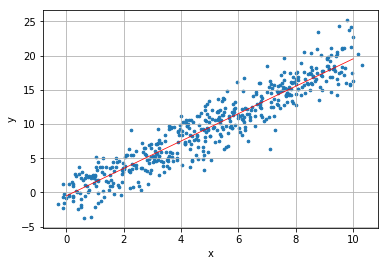

In [50]:
# Volvemos a representar una muestra de nuestros datos para superponer las predicciones anteriormente calculadas.
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.plot(np.linspace(0,10,10), predictions, 'r', linewidth = .75)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Con esto hemos conseguido abordar un problema de regresión lineal con un data set extenso de manera satisfactoria haciendo uso de TensorFlow.